In [1]:
#import sys
import os
import datetime
import pandas as pd
import numpy as np
from datagenPendulum import get_pendulum_data
from sindy_utils import library_size
from sindy_library import SINDyLibrary
#from training import train_network
import torch as tc
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
# Get cpu or gpu device for training.
device = "cuda" if tc.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


# Buscando dados de treino

In [2]:
training_data = get_pendulum_data(100)
validation_data = get_pendulum_data(10)

KeyboardInterrupt: 

Text(0.5, 1.0, 'dz')

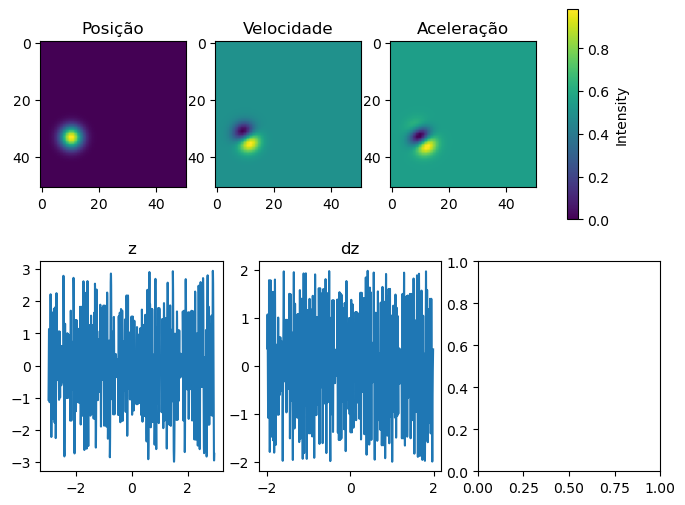

In [ ]:
X, dX,ddX,z,dz = training_data['x'], training_data['dx'], training_data['ddx'], training_data['z'], training_data['dz']


fig, axs = plt.subplots(2, 3, figsize=(8, 6))  # 5 rows, 1 column

# Plot the first subplot
im1 = axs[0,0].imshow(X[0].reshape(51,51))
axs[0,0].set_title('Posição')
cbar1 = fig.colorbar(im1, ax=axs[0])
cbar1.set_label('Intensity')
im2 = axs[0,1].imshow(dX[0].reshape(51,51))
axs[0,1].set_title('Velocidade')
im3 = axs[0,2].imshow(ddX[0].reshape(51,51))
axs[0,2].set_title('Aceleração')
axs[1,0].plot(np.linspace(min(z),max(z),len(z)),z)
axs[1,0].set_title('z')
axs[1,1].plot(np.linspace(min(dz),max(dz),len(dz)),dz)
axs[1,1].set_title('dz')


# Plot the second subplot


#plt.subplot()
#plt.imshow(X[0].reshape((51,51)))
#plt.colorbar()

# Declarando parâmetros

In [ ]:
params = {}

params['input_dim'] = training_data['x'].shape[-1]
params['latent_dim'] = 1
#params['model_order'] = 2
params['poly_order'] = 4
params['include_sine'] = True
params['library_dim'] = library_size(2*params['latent_dim'], params['poly_order'], params['include_sine'], True)

# sequential thresholding parameters
params['sequential_thresholding'] = True
params['coefficient_threshold'] = 0.1
params['threshold_frequency'] = 500
params['coefficient_mask'] = np.ones((params['library_dim'], params['latent_dim']))
params['coefficient_initialization'] = 'constant'

# loss function weighting
params['loss_weight_decoder'] = 1.0
params['loss_weight_sindy_x'] = 5e-4
params['loss_weight_sindy_z'] = 5e-5
params['loss_weight_sindy_regularization'] = 1e-5

params['activation'] = 'sigmoid'
params['widths'] = [128,64,32]

# training parameters
params['epoch_size'] = training_data['x'].shape[0]
params['batch_size'] = 64
params['learning_rate'] = 1e-4

params['data_path'] = os.getcwd() + '/'
params['print_progress'] = True
params['print_frequency'] = 100

# training time cutoffs
params['max_epochs'] = 5001
params['refinement_epochs'] = 1001


## Declarando Rede

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(Encoder, self).__init__()
        self.fc0 = nn.Linear(input_size,256)
        self.fc1 = nn.Linear(256,128)
        self.fc33 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32,latent_dim)
        self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            print(m)
            if isinstance(m, nn.Linear):
                #nn.init.xavier_normal_(m.weight) #per la sigmoid
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = tc.relu(self.fc0(x))
        x = tc.relu(self.fc1(x))
        x = tc.relu(self.fc2(x))
        x = tc.relu(self.fc33(x))
        x = tc.relu(self.fc3(x))   
        x = tc.relu(self.fc4(x))
        return x 

class Decoder(nn.Module):
    def __init__(self, input_size,latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim,32)
        self.fc2 = nn.Linear(32,64)
        self.fc3 = nn.Linear(64,128)
        self.fc33 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(128,256)
        self.fc5 = nn.Linear(256,input_size)
        self.initialize_weights()

    def forward(self, x):
        x = tc.relu(self.fc1(x))
        x = tc.relu(self.fc2(x))
        x = tc.relu(self.fc33(x))   
        x = tc.relu(self.fc3(x))
        x = tc.relu(self.fc4(x))
        x = tc.sigmoid(self.fc5(x))
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                #nn.init.xavier_normal_(m.weight)
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)

class Autoencoder(nn.Module):
    def __init__(self, params):
        super(Autoencoder, self).__init__()
        # importing parameters 
        input_size = params['input_dim']
        latent_dim = params['latent_dim']
        if 'include_sine' in params.keys():
            include_sine = params['include_sine']
        else:
            include_sine = False
        
        # defining network bits
        self.encoder = Encoder(input_size,latent_dim)
        self.decoder = Decoder(input_size,latent_dim)
        self.SINDyLibrary = SINDyLibrary(
            device=device,
            latent_dim=latent_dim,
            include_biases=False,
            include_states=True,
            include_sin=params['include_sine'],
            include_cos=False,
            include_multiply_pairs=False, #non ho capito cosa é ma conta due volte le coppie  
            poly_order=params['poly_order'],
            include_sqrt=False,
            include_inverse= False,
            include_sign_sqrt_of_diff=False)
        
        self.XI = nn.Parameter(tc.full((self.SINDyLibrary.number_candidate_functions,latent_dim),1.,dtype = tc.float32,requires_grad=True,device = device))
        #self.XI = nn.Parameter(torch.randn((self.SINDyLibrary.number_candidate_functions,latent_dim),
        self.XI_coefficient_mask = tc.ones((self.SINDyLibrary.number_candidate_functions,latent_dim),dtype = tc.float32, device=device)


    def configure_optimizers(self):
        learning_rate = params['learning_rate']
        #learning_rate = 1e-4
        #return tc.optim.SGD(self.parameters(), lr=learning_rate, momentum = 0.9)
        return tc.optim.Adam(self.parameters(), lr=learning_rate)

    def z_derivative_order2(self, input, dx, ddx, weights, biases, activation='relu'):
        """
        Compute the first and second order time derivatives by propagating through the network.

        Arguments:
            input - 2D PyTorch tensor, input to the network. Dimensions are number of time points
            by number of state variables.
            dx - First order time derivatives of the input to the network.
            ddx - Second order time derivatives of the input to the network.
            weights - List of PyTorch tensors containing the network weights
            biases - List of PyTorch tensors containing the network biases
            activation - String specifying which activation function to use. Options are
            'elu', 'relu', 'sigmoid', or 'linear'.

        Returns:
            dz - PyTorch tensor, first order time derivatives of the network output.
            ddz - PyTorch tensor, second order time derivatives of the network output.
        """
        dz = dx
        ddz = ddx

        for i in range(len(weights)-1):
            input = tc.matmul(input, weights[i].T) + biases[i]
            dz_prev = tc.matmul(dz, weights[i].T)

            if activation == 'elu':
                elu_derivative = tc.where(input < 0, tc.exp(input), tc.tensor(1.0))
                elu_derivative2 = tc.exp(input) * (input < 0).float()
                dz = elu_derivative * dz_prev
                ddz = elu_derivative2 * dz_prev.pow(2) + elu_derivative * tc.matmul(ddz, weights[i].T)
                input = F.elu(input)

            elif activation == 'relu':
                relu_derivative = (input > 0).float()
                dz = relu_derivative * tc.matmul(dz, weights[i].T)
                ddz = relu_derivative * tc.matmul(ddz, weights[i].T)
                input = F.relu(input)

            elif activation == 'sigmoid':
                sigmoid = tc.sigmoid(input)
                sigmoid_derivative = sigmoid * (1 - sigmoid)
                sigmoid_derivative2 = sigmoid_derivative * (1 - 2 * sigmoid)
                dz = sigmoid_derivative * dz_prev
                ddz = sigmoid_derivative2 * dz_prev.pow(2) + sigmoid_derivative * tc.matmul(ddz, weights[i].T)

            else:  # Linear activation
                dz = tc.matmul(dz, weights[i].T)
                ddz = tc.matmul(ddz, weights[i].T)

        # Final layer without activation
        dz = tc.matmul(dz, weights[-1].T) + biases[-1]
        ddz = tc.matmul(ddz, weights[-1].T) + biases[-1]

        return dz, ddz
    
    def compute_quantities(self,x,xdot,xddot):
        ##################### VER ISSO AQUI CÓDIGO CPIADO ###################
        # Placeholder for inputs
        ''' tensorflow code
        x = tc.randn(size=(batch_size, input_dim))  # Example tensor for 'x'
        dx = tc.randn(size=(batch_size, input_dim))  # Example tensor for 'dx'
        ddx = tc.randn(size=(batch_size, input_dim))  # Example tensor for 'ddx'

        z, x_decode, encoder_weights, encoder_biases, decoder_weights, decoder_biases = nonlinear_autoencoder(x, input_dim, latent_dim, params['widths'], activation=activation)
        dz, ddz = z_derivative_order2(x, dx, ddx, encoder_weights, encoder_biases, activation=activation)  # Use the adapted function
        Theta = sindy_library_tc_order2(z, dz, latent_dim, poly_order, include_sine)  # Assuming sindy_library_order2 is also adapted to PyTorch
        #'''
        #x0 = x.cpu()
        #plt.imshow(x0[0].reshape(51,51))
        z = self.encoder(x)
        xtilde = self.decoder(z)

        theta = self.SINDyLibrary.transform(z) 
        scindy_predict = tc.matmul(theta, self.XI_coefficient_mask * self.XI)
        
        encoder_parameters = list(self.encoder.parameters())
        encoder_weight_list = [w for w in encoder_parameters if len(w.shape) == 2]
        encoder_biases_list = [b for b in encoder_parameters if len(b.shape) == 1]
        #if model_order == 1:
        #zdot = self.t_derivative(x, xdot, encoder_weight_list, encoder_biases_list, activation='relu')                                               
        #else:
        zdot , zddot = self.z_derivative_order2(x, xdot, xddot, encoder_weight_list, encoder_biases_list)#, activation='relu')

        #print("propagazione sobre o decoder")
        decoder_parameters = list(self.decoder.parameters())
        decoder_weight_list = [w for w in decoder_parameters if len(w.shape) == 2]
        decoder_biases_list = [b for b in decoder_parameters if len(b.shape) == 1]
        xtildedot , xtildeddot = self.z_derivative_order2(z, zdot, scindy_predict, decoder_weight_list, decoder_biases_list, activation='relu')    
        
        return xtilde, xtildedot, xtildeddot, z, zdot, zddot, scindy_predict

    def loss_function(self, x, xdot, xddot, xtilde, xtildedot, xtildeddot, zdot, zddot, scindy_predict,XI):
        mse = nn.MSELoss()
        alpha1 = 5e-4
        alpha2 = 5e-5
        alpha3 = 1e-5


        loss = {}
        loss['recon_loss'] = mse(x, xtilde) #errore di ricostruzione 
        #loss ['sindy_loss_x'] = mse(xdot, xtildedot) 
        loss ['sindy_loss_z'] = mse(zddot, scindy_predict) 
        loss ['sindy_loss_ddx'] = mse(xddot,xtildeddot)
        loss['sindy_regular_loss'] = tc.sum(tc.abs(XI)) #norma L1 degli XI
        loss['tot'] = loss['recon_loss'] + alpha1*loss['sindy_loss_ddx'] + alpha2*loss['sindy_loss_z'] + alpha3*loss['sindy_regular_loss']
        #loss['tot'] = loss['recon_loss'] + alpha1*(loss['sindy_loss_ddx'] + loss['sindy_loss_x']) + alpha2*loss['sindy_loss_z'] + alpha3*loss['sindy_regular_loss']
        tot = loss['tot']
        return tot, loss
    
    
    def forward(self, x, xdot, xddot):
        return self.compute_quantities(x, xdot, xddot)

In [ ]:

model = Autoencoder(params).to(device)

Encoder(
  (fc0): Linear(in_features=2601, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc33): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)
Linear(in_features=2601, out_features=256, bias=True)
Linear(in_features=256, out_features=128, bias=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=1, bias=True)


In [ ]:
model.SINDyLibrary.feature_names


['z0', 'sin(z0)', 'z0*z0', 'z0*z0*z0', 'z0*z0*z0*z0']

## Olhando os dados

In [ ]:
X[1]

array([9.10358191e-39, 3.85400677e-38, 1.41277902e-37, ...,
       2.03622921e-53, 8.58387476e-56, 3.13329782e-58])

Convertendo para tensores de Pytorch

In [ ]:
X = tc.from_numpy(X).float().to(device)
dX = tc.from_numpy(dX).float().to(device)
ddX = tc.from_numpy(ddX).float().to(device)
z = tc.from_numpy(z).float().to(device)
dz = tc.from_numpy(dz).float().to(device)


X.shape, dX.shape, X.dtype

(torch.Size([50000, 2601]), torch.Size([50000, 2601]), torch.float32)

In [ ]:
X[1], dX[1], ddX[1], z[1], dz[1]


(tensor([9.1036e-39, 3.8540e-38, 1.4128e-37,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00], device='cuda:0'),
 tensor([-2.8696e-37, -1.1972e-36, -4.3240e-36,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00], device='cuda:0'),
 tensor([8.3682e-36, 3.4374e-35, 1.2221e-34,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00], device='cuda:0'),
 tensor([-1.0526], device='cuda:0'),
 tensor([0.3852], device='cuda:0'))

## escolhendo dados de validação

In [ ]:
X_val = tc.from_numpy(validation_data['x']).float().to(device)
dX_val = tc.from_numpy(validation_data['dx']).float().to(device)
ddX_val = tc.from_numpy(validation_data['ddx']).float().to(device)
z_val = tc.from_numpy(validation_data['z']).float().to(device)
dz_val = tc.from_numpy(validation_data['dz']).float().to(device)


In [ ]:
train_size, val_size = X.shape[0], X_val.shape[0]
batch_size =  640
dataset = TensorDataset(X,dX,ddX)
validation_set = TensorDataset(X_val,dX_val,ddX_val)
#train_subset, val_subset = tc.utils.data.random_split(my_dataset, [train_size, val_size])

train_loader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
val_loader   = DataLoader(validation_set, shuffle=False, batch_size=batch_size)

# Treinamento

In [ ]:
def save_model(t,saving_rate,exp):
    '''saves model into a .npy file'''
    if SAVE == True:
        if t % saving_rate == 0 and t > 0:
            print('saved in ',t,"epoche")
            f1 = path + 'model'+str(exp) + '_' + str(t) + 'epochs' + '.pt'
            tc.save({
            'epoch': t,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': model.configure_optimizers().state_dict(),
            'loss': model.loss_function,
            'sindy_coefficients': model.XI,
            'coefficient_mask' : model.XI_coefficient_mask
            }, f1)
            
            XI = model.XI.cpu().detach().numpy()
            np.save(path + 'model'+str(exp) + '_' + str(t) + 'epochs' + '.npy',XI)

def print_model(t,exp):
    f = open(path + 'model'+str(exp)+'_equation' + '_' + str(t) + '.txt', 'w')
    coefficient_mask = model.XI_coefficient_mask.cpu().detach().numpy()
    XI = model.XI.cpu().detach().numpy()
    feature_list = model.SINDyLibrary.get_feature_names()
    latent_dim = params['latent_dim']
    for j in range(latent_dim):
        k=0
        for i in range(len(feature_list)-1):
            coeff = XI[i][j] * coefficient_mask[i][j]      
            if  abs(coeff) >= 0.1 and coeff != 0:
                #print(f"dz{j} = {coeff:.4f} {feature_list[i]}")
                if k<1:
                    f.write(f"ddz{j} = {coeff:.6f} {feature_list[i]}")
                else:
                    f.write(f"+ {coeff:.6f} {feature_list[i]}")
                k+=1
    f.close()

def sequential_threshold(epoch, seq_thres):
    ''' decides when to delete small coefficientes in XI'''
    if (epoch % seq_thres == 0 and epoch>1):
        print('Sequencial threshold, deleting coefficients below 0.1..')
        model.XI_coefficient_mask = tc.abs(model.XI) > 0.1


#training step for one epoch
def train_step(loss_list):
        
    #queste serve per le loss di ogni batch
    loss_epoch = {}
    loss_epoch['recon_loss'] = []
    #loss_epoch['sindy_loss_x'] = []
    loss_epoch['sindy_loss_ddx'] = []
    loss_epoch['sindy_loss_z'] = []
    loss_epoch['sindy_regular_loss'] = []
    loss_epoch['tot'] = []
    
    model.train()
    for batch, (X,Xdot,Xddot) in enumerate (train_loader):
        X.to(device) #per passarlo alla gpu
        Xdot.to(device)
        Xddot.to(device)
        #forward pass 

        xtilde, xtildedot, xtildeddot, z, zdot, zddot, scindy_predict = model(X,Xdot, Xddot)

        # Backpropagation
        optimizer = model.configure_optimizers()

        loss, loss_dict = model.loss_function(X, Xdot,Xddot, xtilde, xtildedot,xtildeddot, zdot,zddot, scindy_predict,model.XI)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()

        for key in loss_epoch.keys():
            loss_epoch[key].append(loss_dict[key].item())
        
        
    for key in loss_epoch.keys():
            loss_list[key].append(sum(loss_epoch[key])/len(loss_epoch[key]))
            
    del loss_epoch,loss_dict,xtilde, xtildedot,xtildeddot, z, zdot, zddot, scindy_predict,loss

def validation_step(loss_val_list):
    loss_val_epoch = []
    model.eval()     # Optional when not using Model Specific layer
    for batch, (X,Xdot, Xddot) in enumerate (val_loader):
        X.to(device) #per passarlo alla gpu
        Xdot.to(device)
        Xddot.to(device)
        #forward pass 
        xtilde, xtildedot, xtildeddot, z, zdot, zddot,scindy_predict = model(X,Xdot, Xddot)
        # validation loss 
        loss, _ = model.loss_function(X, Xdot,Xddot, xtilde, xtildedot,xtildeddot, zdot,zddot, scindy_predict,model.XI)
        loss_val_epoch.append(loss.item())
        del  xtilde, xtildedot, xtildeddot, z, zdot, zddot, scindy_predict,loss

    loss_val_list.append(sum(loss_val_epoch)/len(loss_val_epoch))

def print_loss(t,loss_rate, loss_list):
    if t % loss_rate == 0:
        print()
        print(f"Epoch {t}\n-------------------------------")
        for key in loss_list.keys():
            temp = loss_list[key]
            print(f'{key} of epoch {t}: {temp[-1]:.3e}')

In [ ]:
def plot_validation_comparison(epoch, val_rate):
    if epoch % val_rate == 0 and epoch>1:
        X_p, dX_p,ddX_p= validation_data['x'], validation_data['dx'], validation_data['ddx']#, validation_data['z'], validation_data['dz']

        X_pred, dX_pred, ddX_pred, _, _, _,scindy_predict = model(X_val,dX_val, ddX_val)
        X_pred = X_pred.cpu().detach().numpy()
        dX_pred = dX_pred.cpu().detach().numpy()
        ddX_pred = ddX_pred.cpu().detach().numpy()

        print('\n Model is now:')
        coefficient_mask = model.XI_coefficient_mask.cpu().detach().numpy()
        XI = model.XI.cpu().detach().numpy()
        feature_list = model.SINDyLibrary.get_feature_names()
        latent_dim = params['latent_dim']

        for j in range(latent_dim):
            k=0
            for i in range(len(feature_list)-1):
                coeff = XI[i][j] * coefficient_mask[i][j]      
                if  abs(coeff) >= 0.1 and coeff != 0:
                    #print(f"dz{j} = {coeff:.4f} {feature_list[i]}")
                    if k<1:
                        print(f"ddz{j} = {coeff:.6f} {feature_list[i]}")
                    else:
                        print(f"+ {coeff:.6f} {feature_list[i]}")
                    k+=1

        fig, axs = plt.subplots(2, 3, figsize=(8, 6))  # 5 rows, 1 column

        # Plot the first subplot
        im1 = axs[0,0].imshow(X_p[0].reshape(51,51))
        axs[0,0].set_title('Posição')
        cbar1 = fig.colorbar(im1, ax=axs[0])
        cbar1.set_label('Intensity')
        im2 = axs[0,1].imshow(dX_p[0].reshape(51,51))
        axs[0,1].set_title('Velocidade')
        im3 = axs[0,2].imshow(ddX_p[0].reshape(51,51))
        axs[0,2].set_title('Aceleração')
        im1 = axs[1,0].imshow(X_pred[0].reshape(51,51))
        im2 = axs[1,1].imshow(dX_pred[0].reshape(51,51))
        im3 = axs[1,2].imshow(ddX_pred[0].reshape(51,51))

In [ ]:
VALIDATION = False
SAVE = True

epochs = 2000
#path = '../model/'

path = './saved_models/'

seq_thres = 251   # numero epoche ogni quanto fare seq thres

equation_rate = 500 #print delle equazioni trovate

saving_rate = 500 # numero epoche in cui salvo il modello e gli XI

loss_rate = 250  #print delle loss

val_print_rate = 250

Encoder(
  (fc0): Linear(in_features=2601, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc33): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)
Linear(in_features=2601, out_features=256, bias=True)
Linear(in_features=256, out_features=128, bias=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=1, bias=True)
--------------------------------------------------
Experiment number 0
epoch: [40/ 2000]
Sequencial threshold, deleting coefficients below 0.1..
epoch: [80/ 2000]
Sequencial threshold, deleting coefficients below 0.1..
epoch: [120/ 2000]
Sequencial threshold, deleting coefficients below 0.1..
epoch: [160/ 2000]
epoch: [200/ 2000]
Sequencial threshold, 

/tmp/ipykernel_2639498/2887938334.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(2, 3, figsize=(8, 6))  # 5 rows, 1 column


Sequencial threshold, deleting coefficients below 0.1..
epoch: [1280/ 2000]
epoch: [1320/ 2000]
Sequencial threshold, deleting coefficients below 0.1..
epoch: [1360/ 2000]
Sequencial threshold, deleting coefficients below 0.1..
epoch: [1400/ 2000]
Sequencial threshold, deleting coefficients below 0.1..
epoch: [1440/ 2000]
Sequencial threshold, deleting coefficients below 0.1..
epoch: [1480/ 2000]

Epoch 1500
-------------------------------
recon_loss of epoch 1500: 3.111e-03
sindy_loss_ddx of epoch 1500: 1.285e+01
sindy_loss_z of epoch 1500: 1.538e+00
sindy_regular_loss of epoch 1500: 2.352e-01
tot of epoch 1500: 9.615e-03
saved in  1500 epoche

 Model is now:
ddz0 = 0.235963 sin(z0)
epoch: [1520/ 2000]
Sequencial threshold, deleting coefficients below 0.1..
epoch: [1560/ 2000]
Sequencial threshold, deleting coefficients below 0.1..
epoch: [1600/ 2000]
Sequencial threshold, deleting coefficients below 0.1..
epoch: [1640/ 2000]
epoch: [1680/ 2000]
Sequencial threshold, deleting coeffici

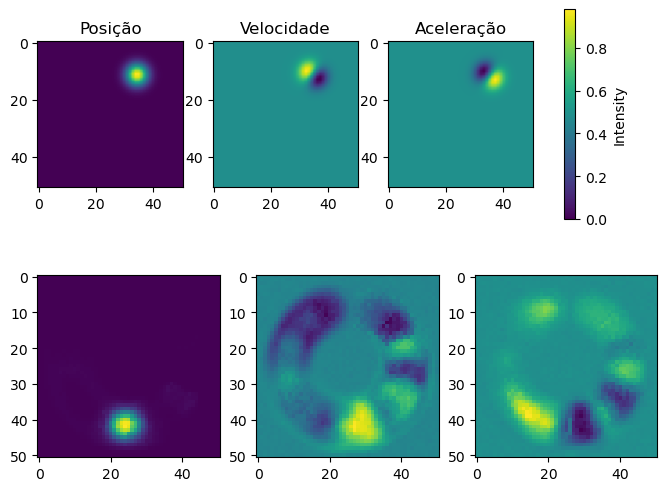

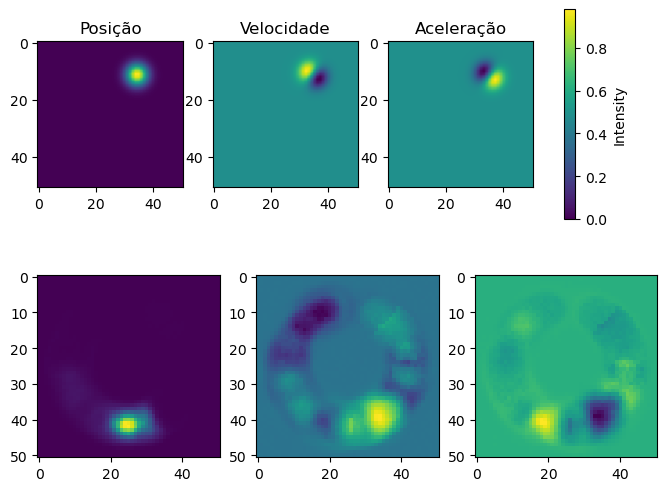

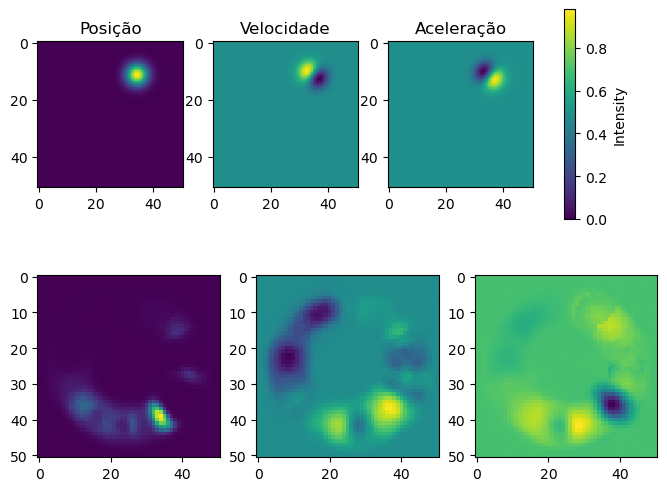

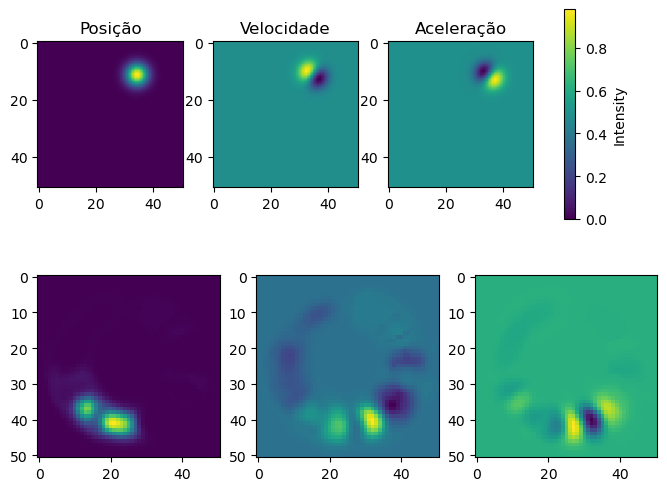

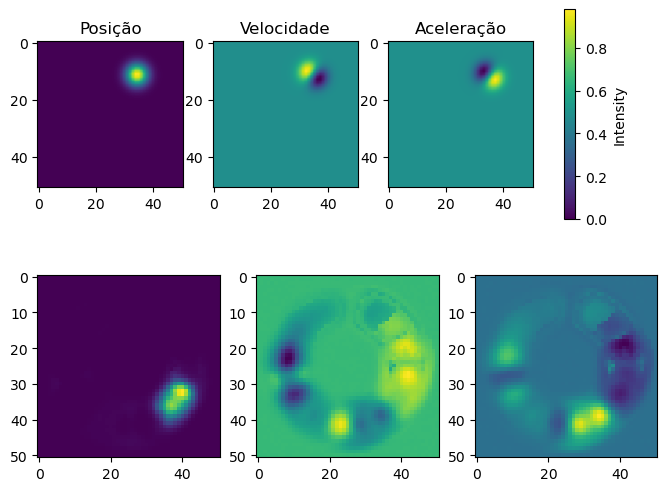

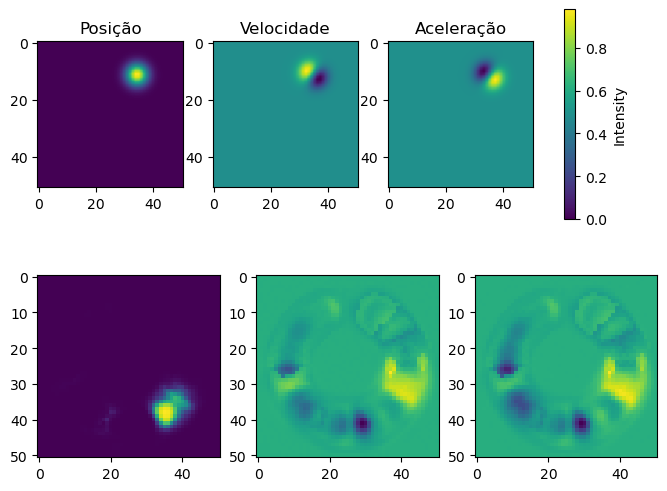

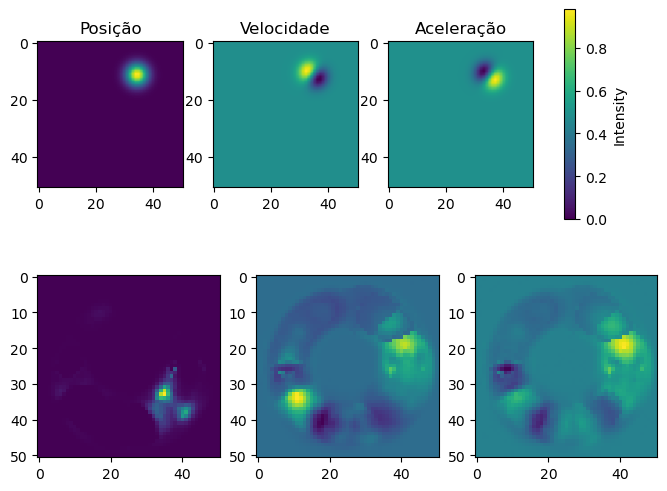

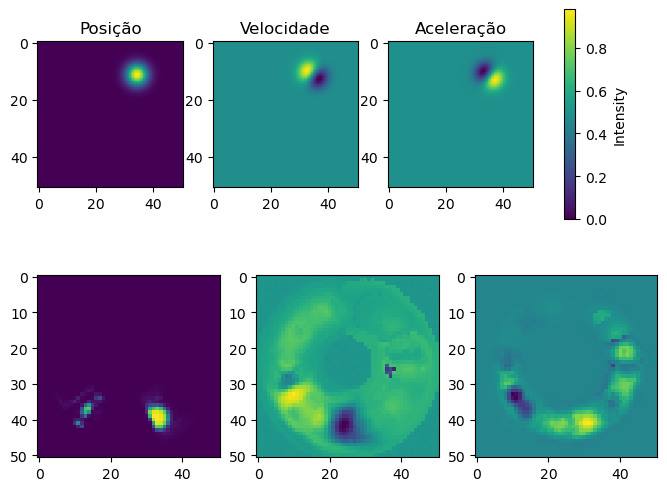

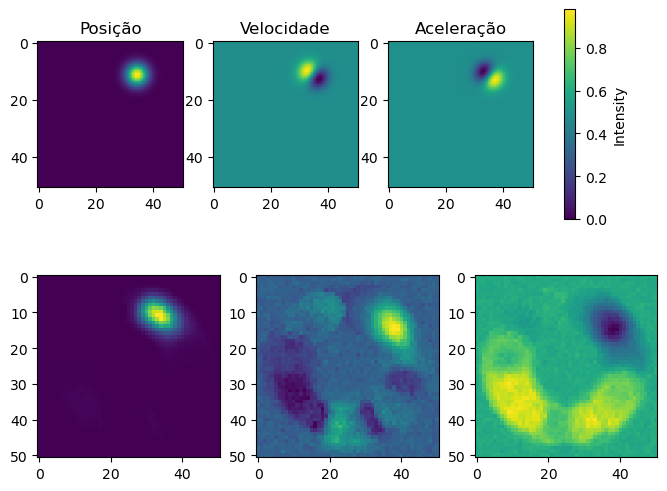

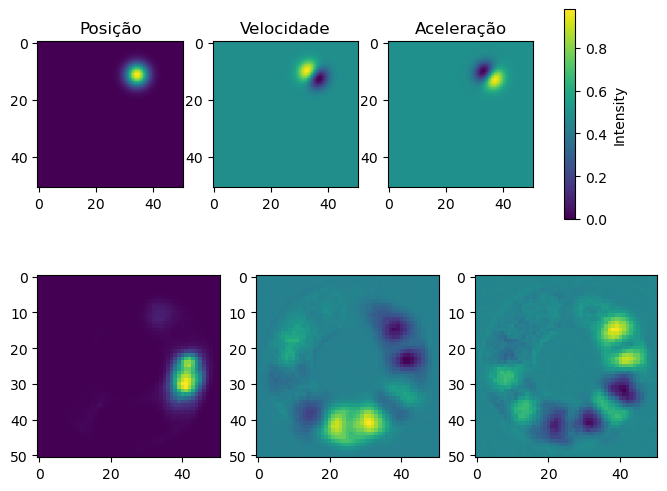

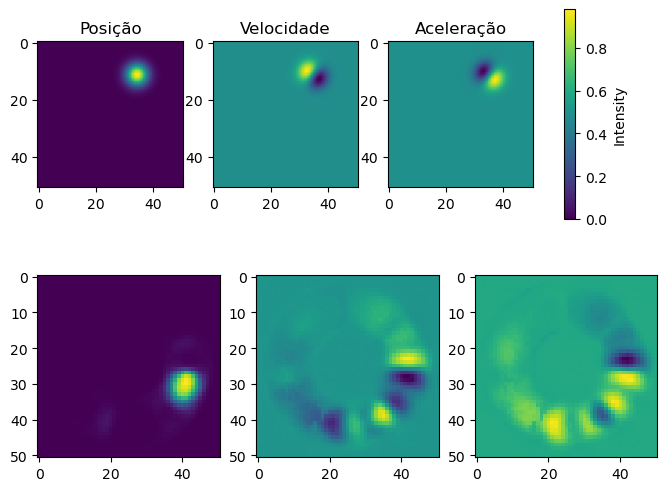

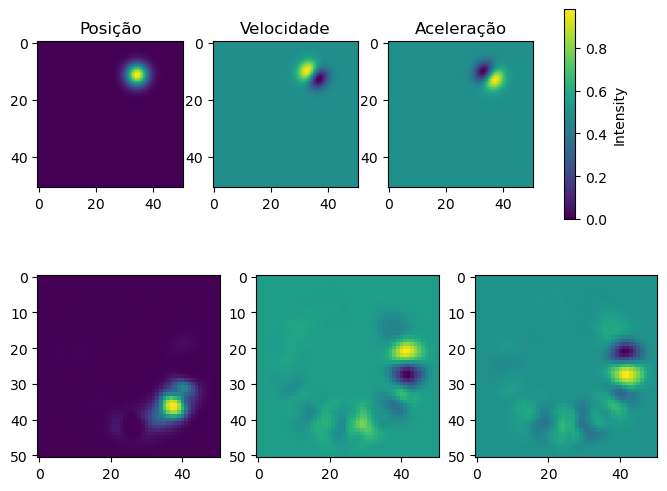

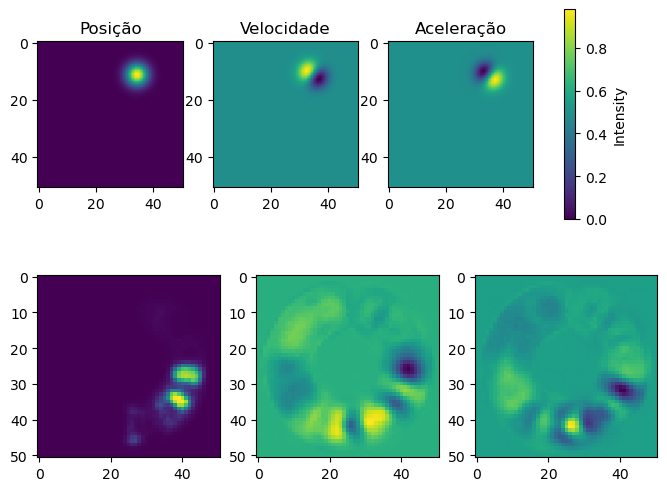

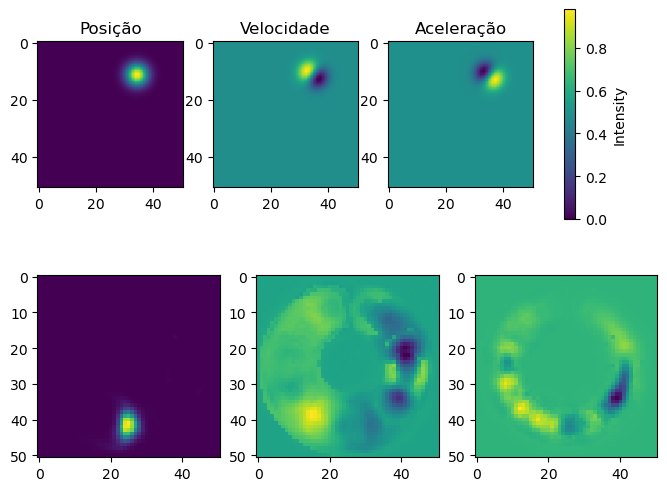

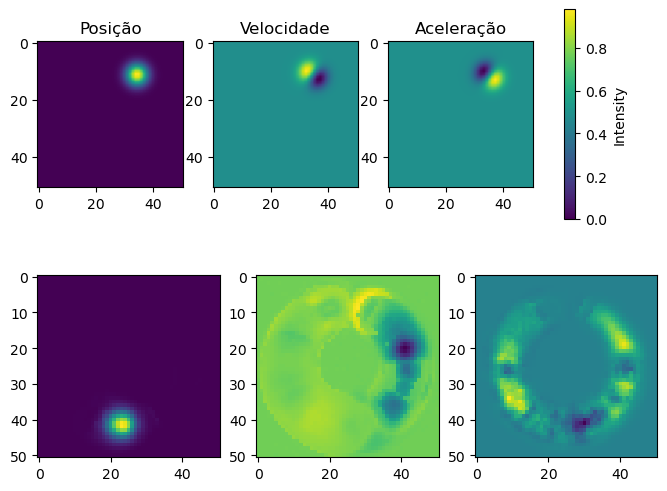

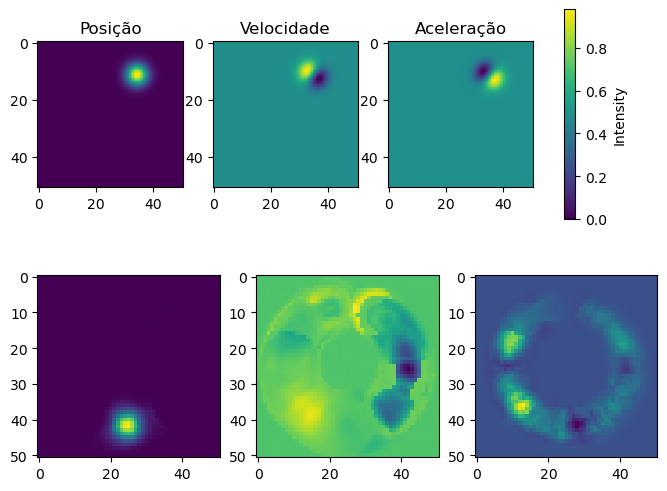

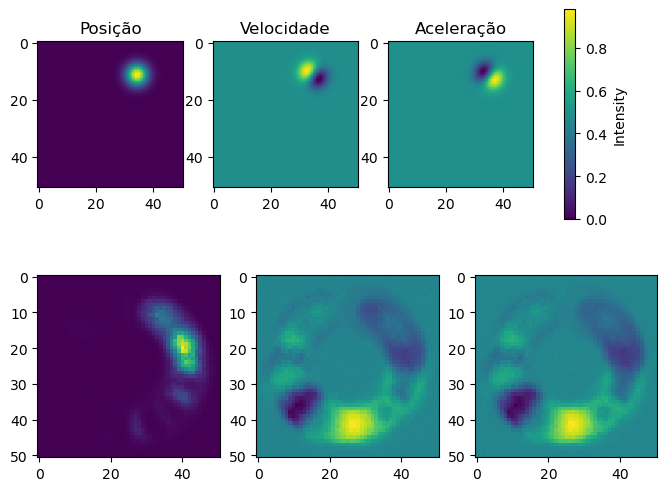

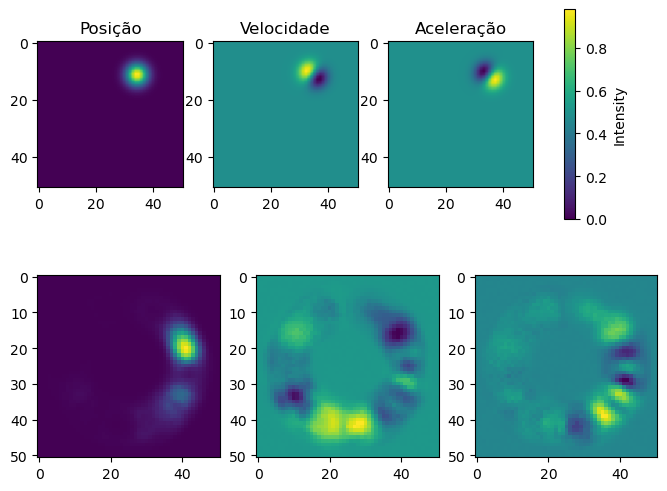

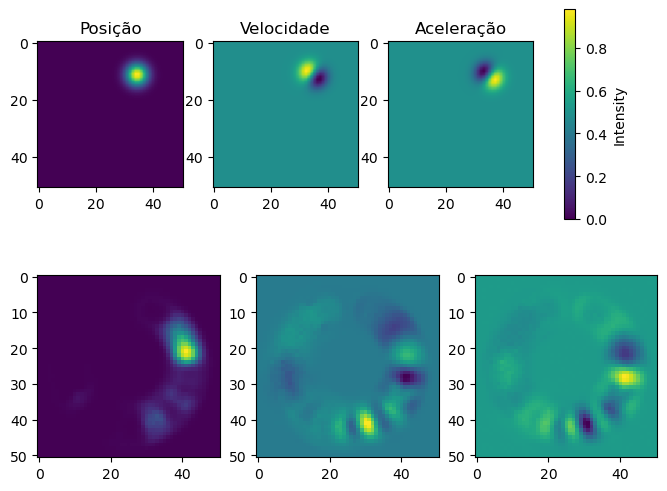

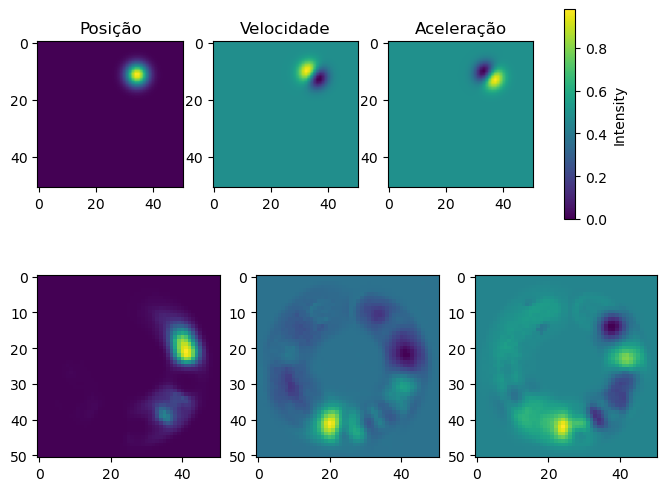

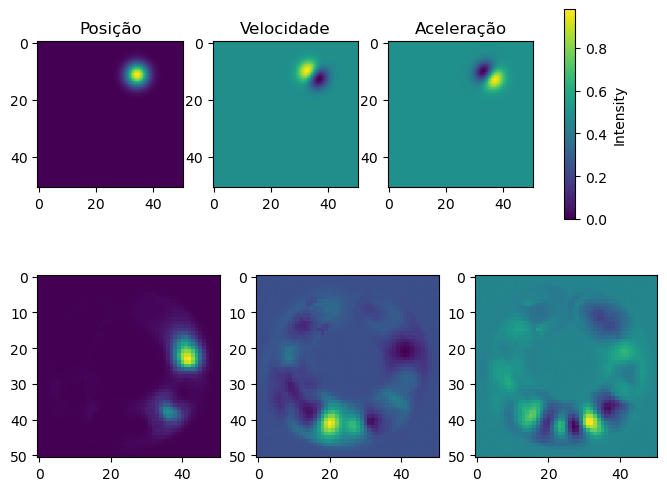

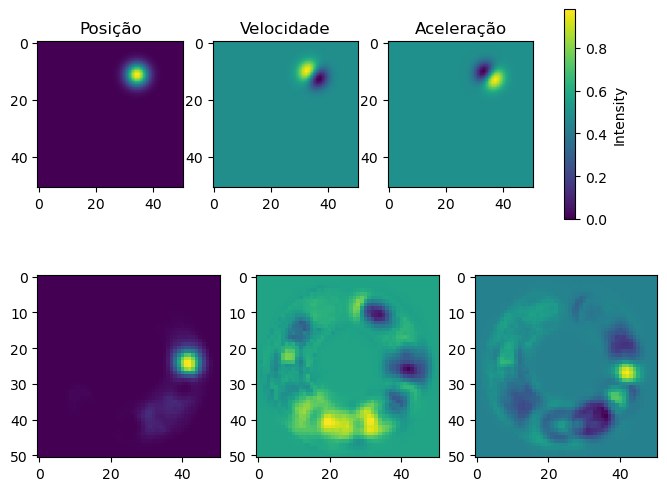

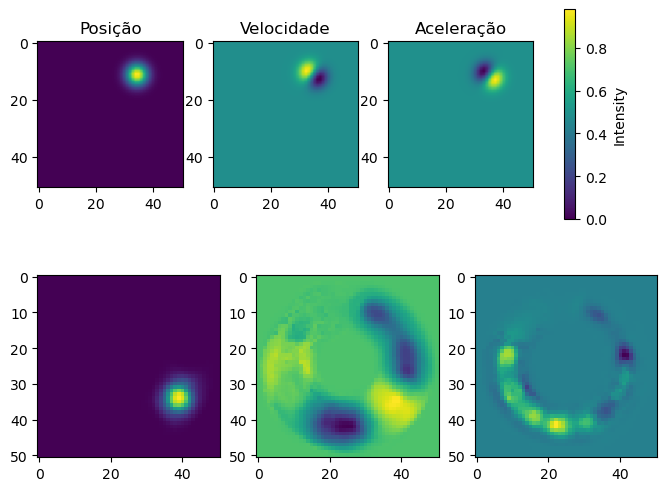

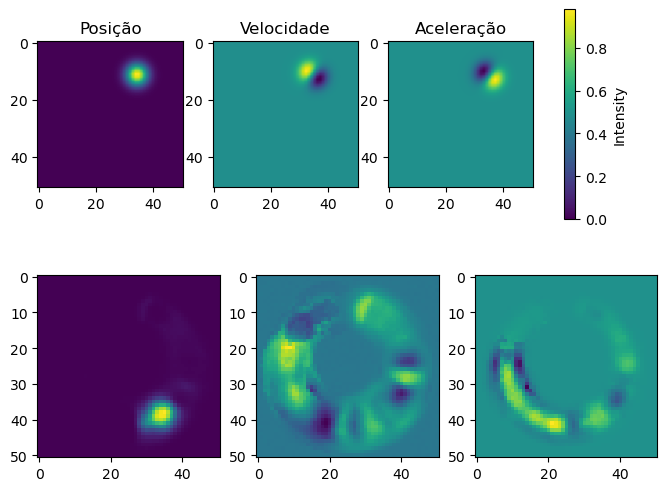

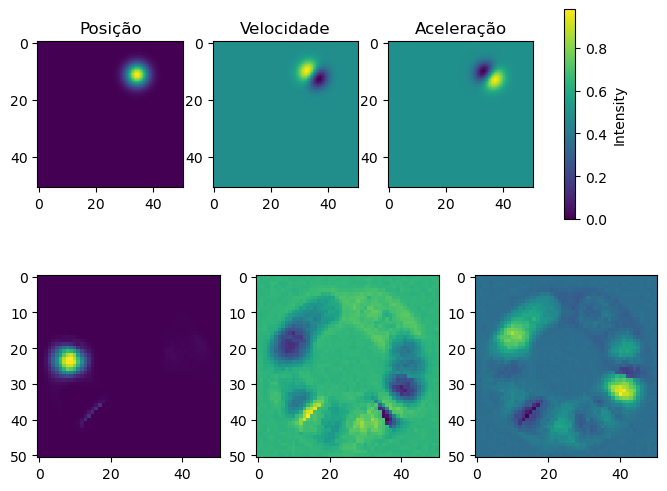

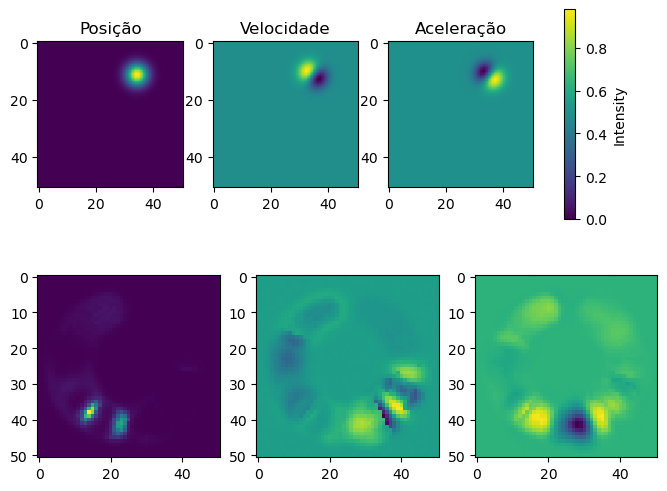

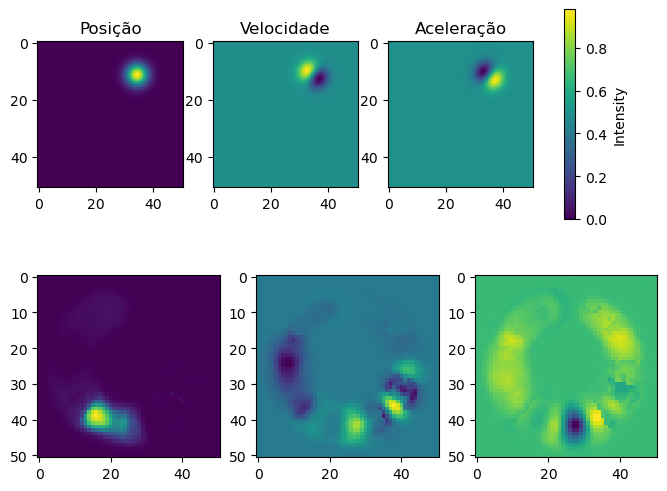

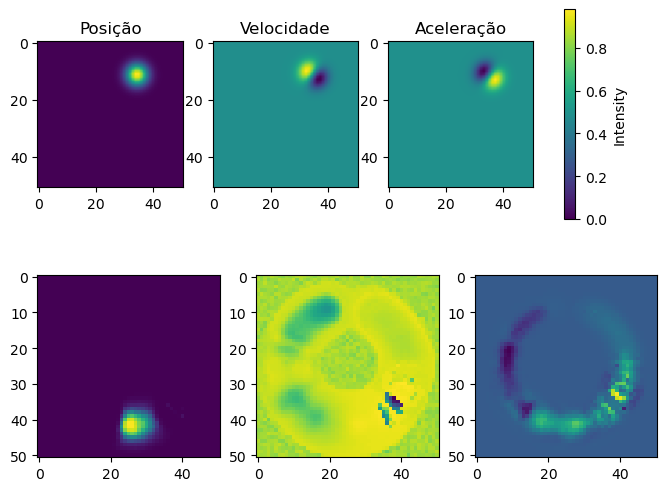

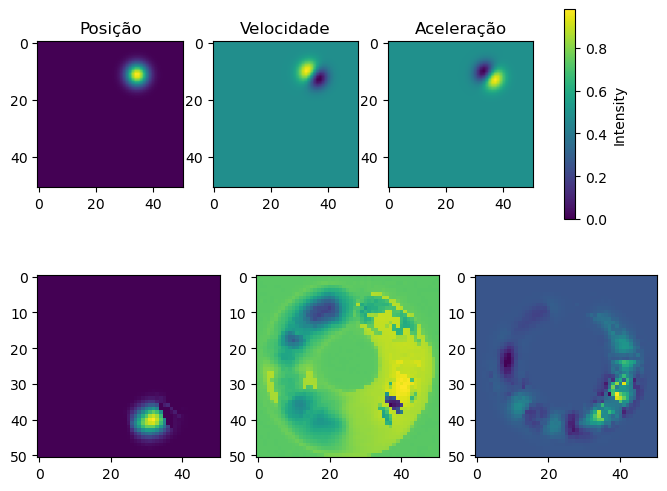

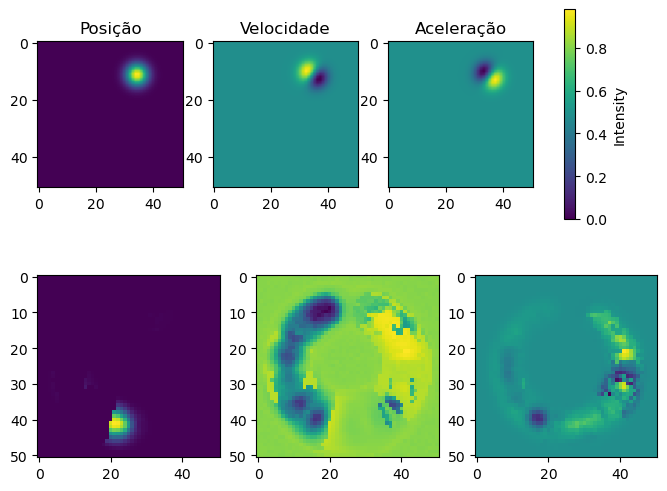

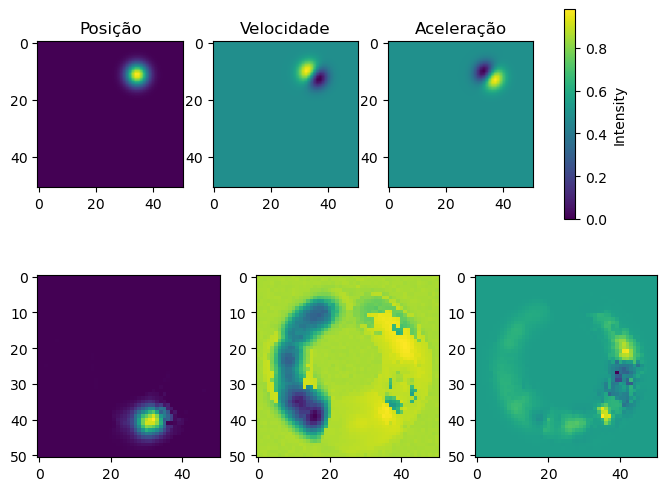

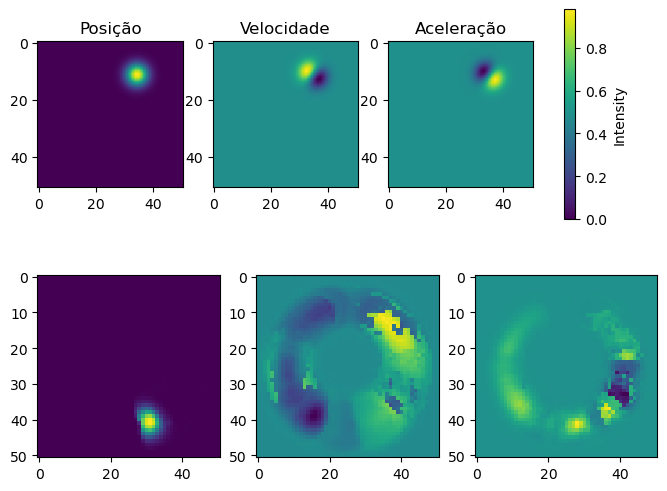

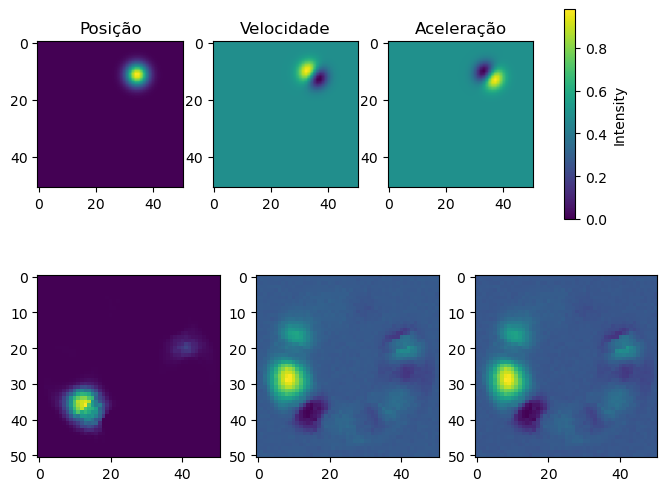

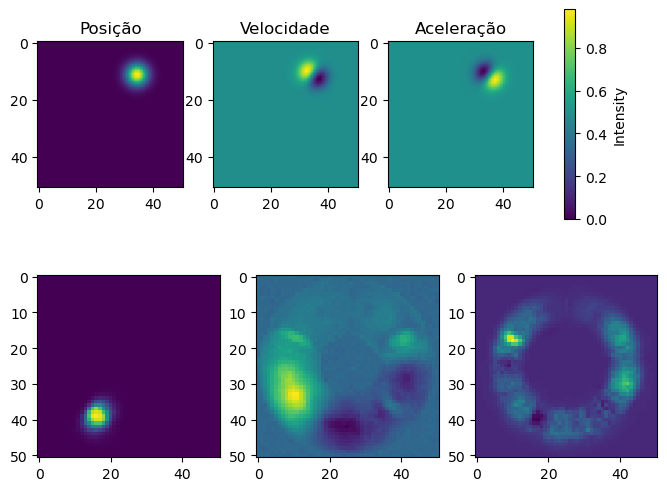

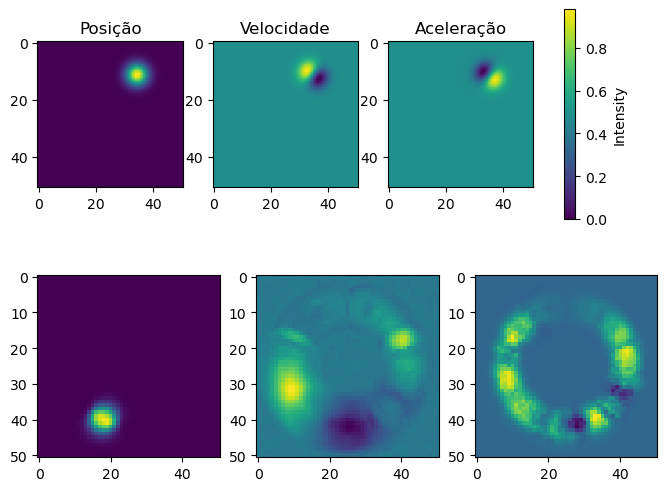

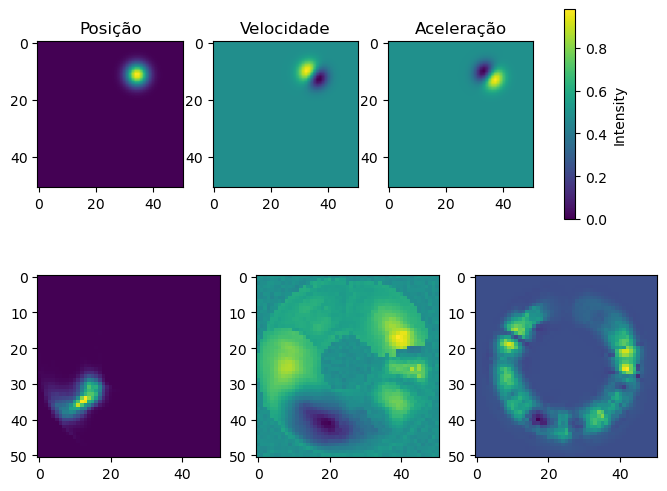

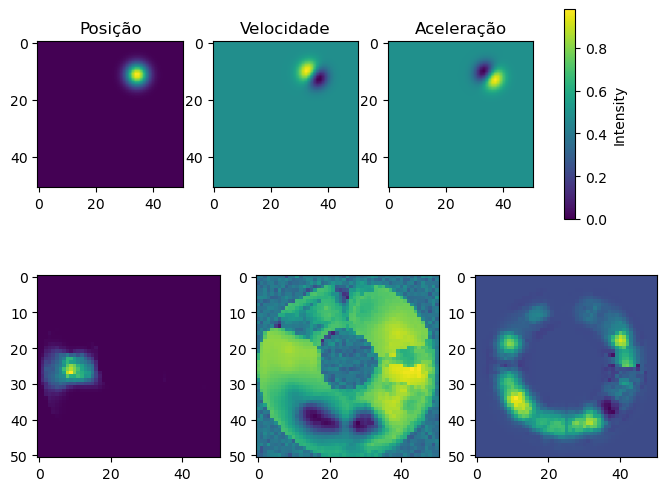

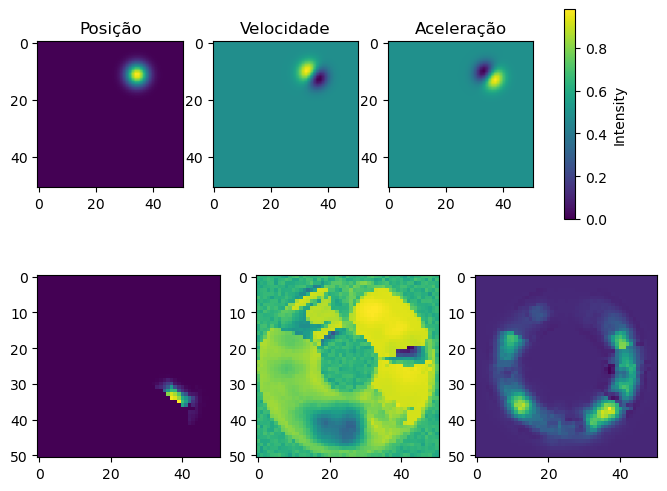

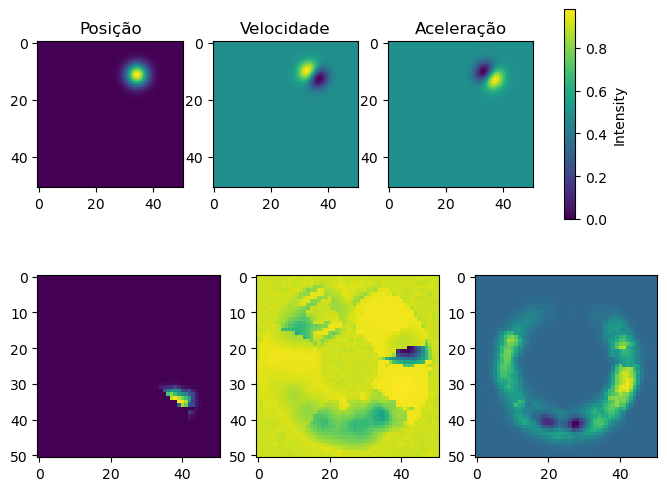

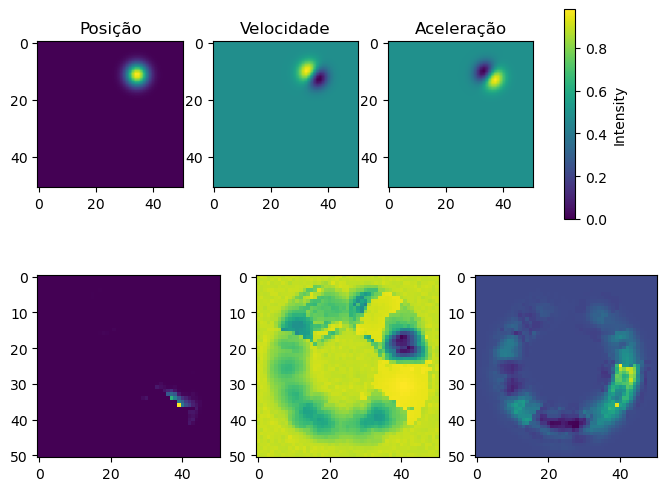

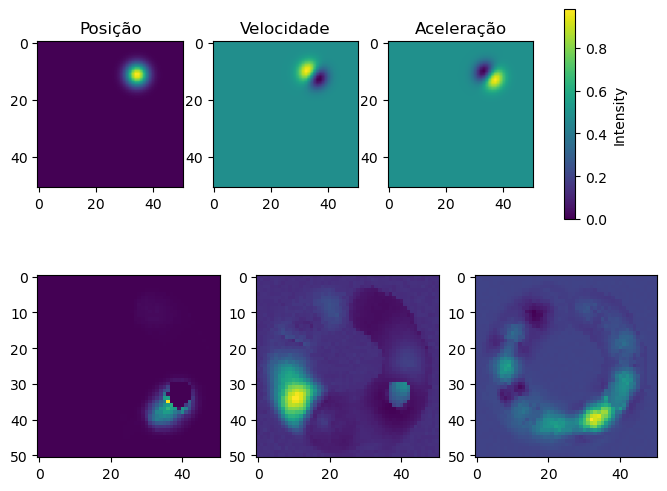

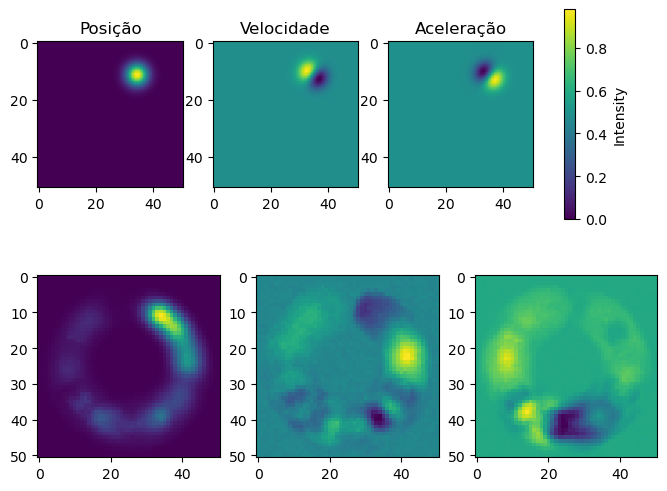

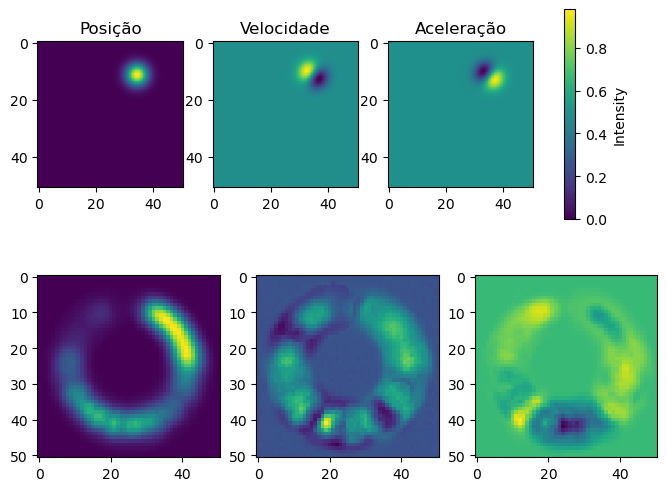

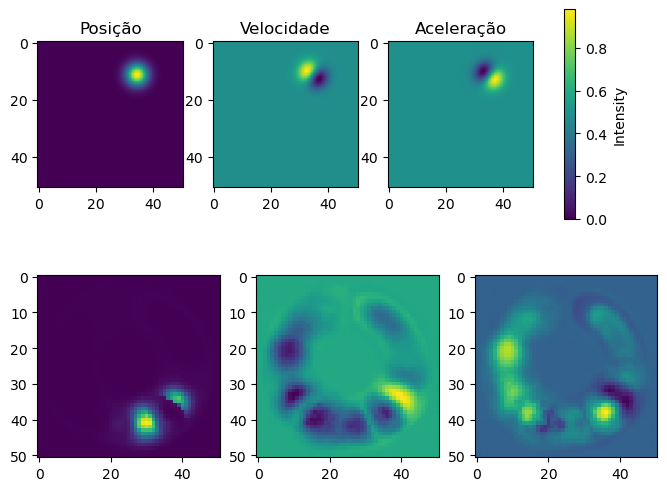

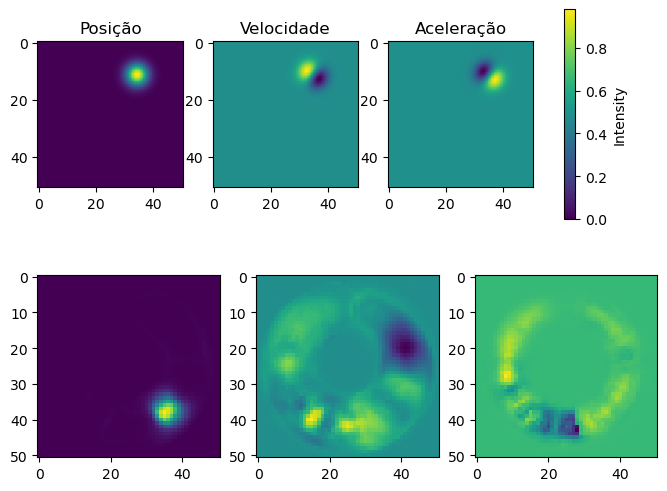

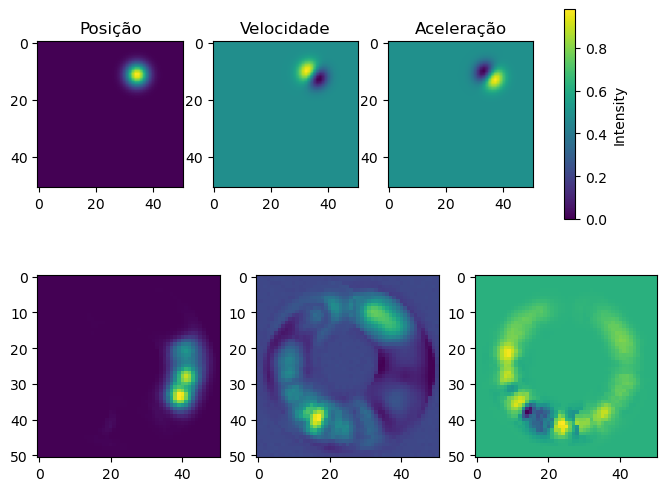

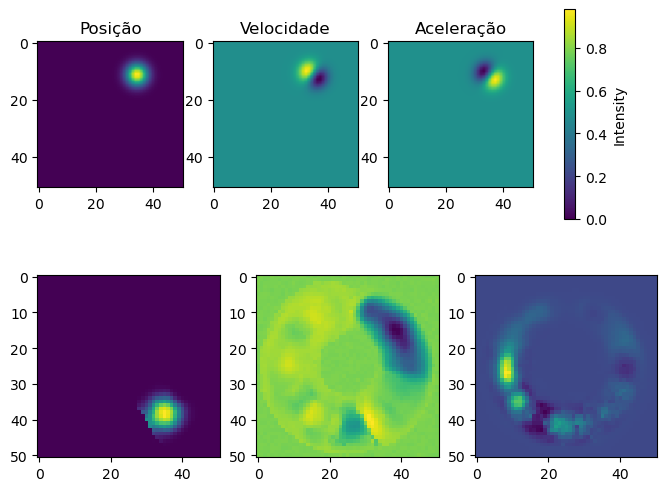

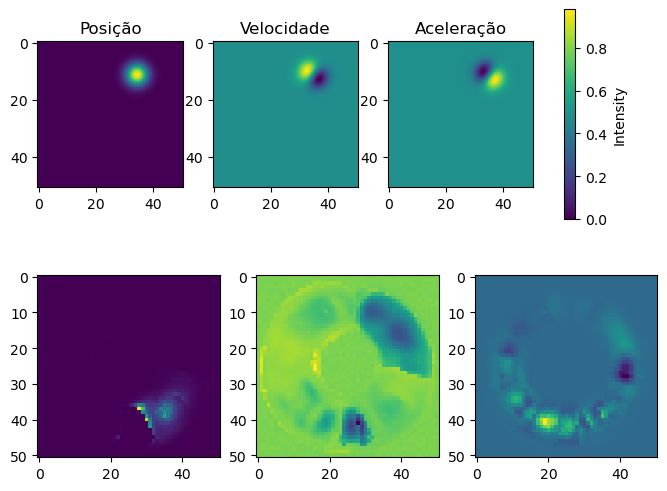

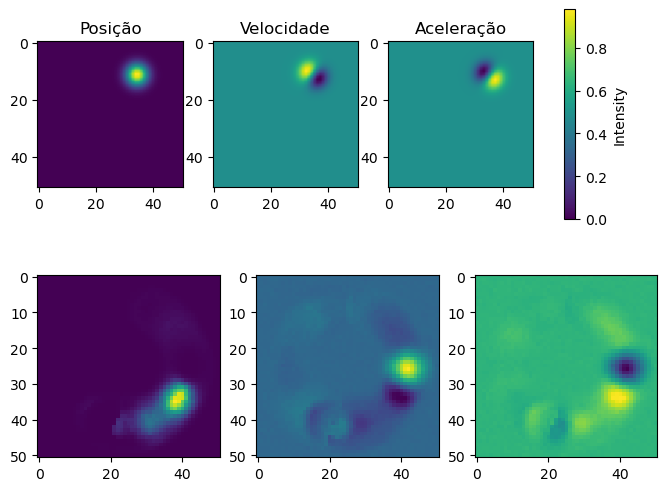

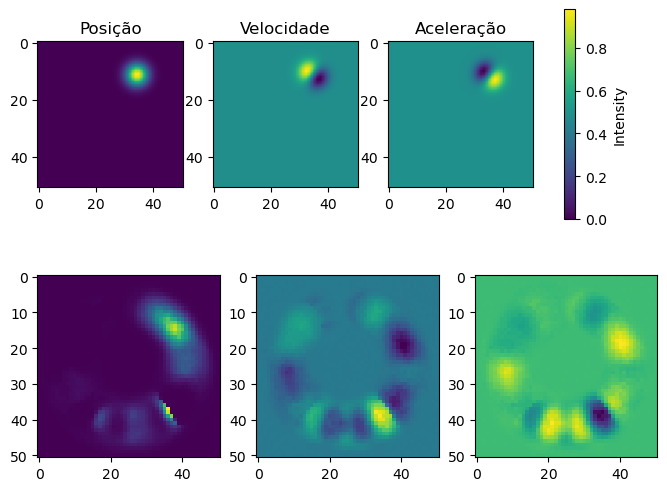

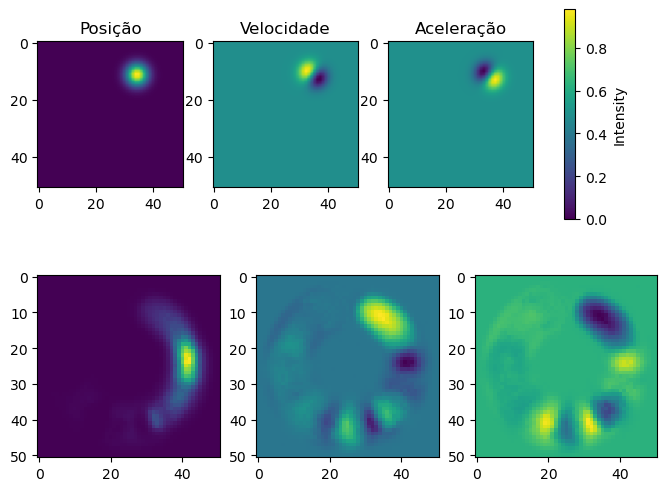

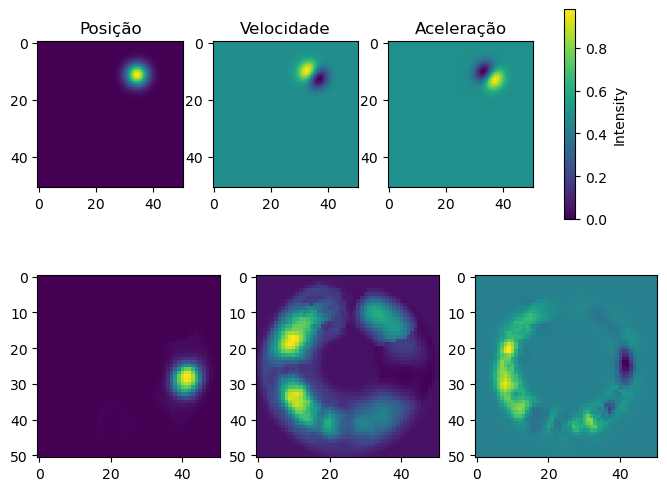

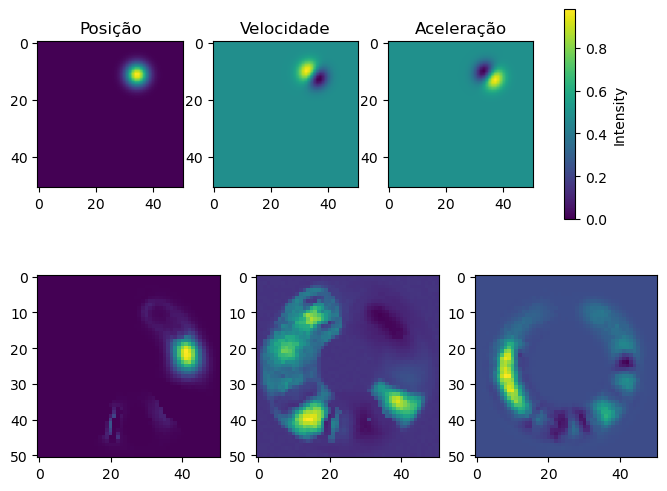

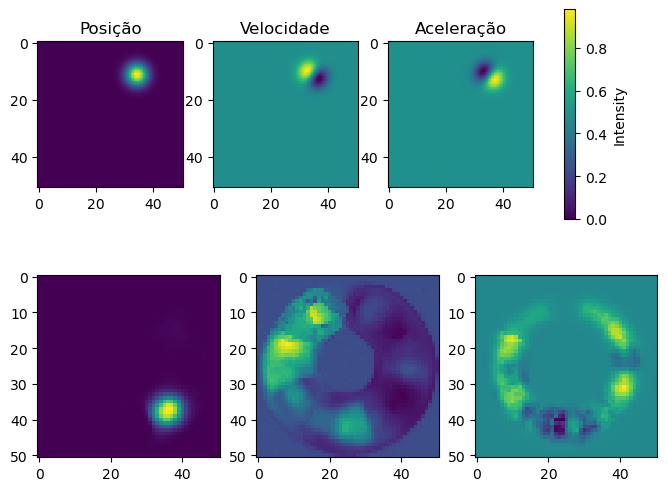

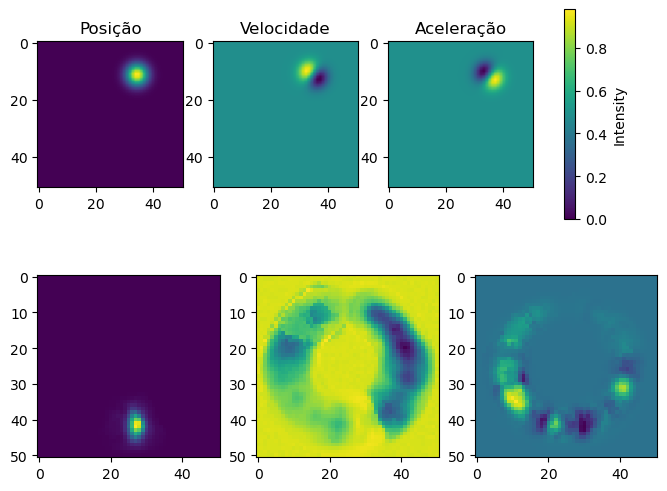

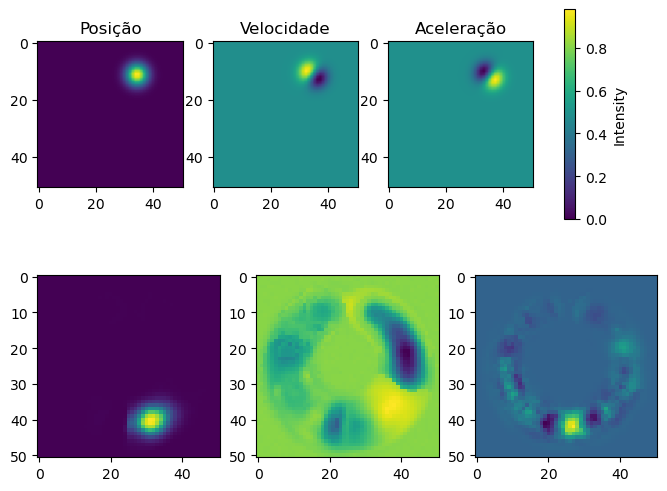

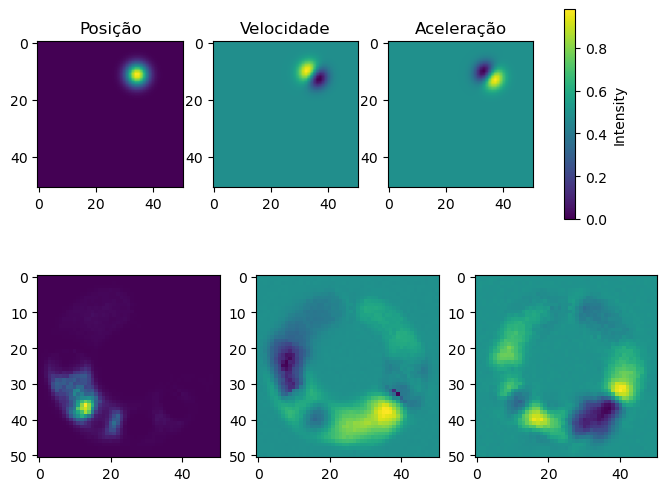

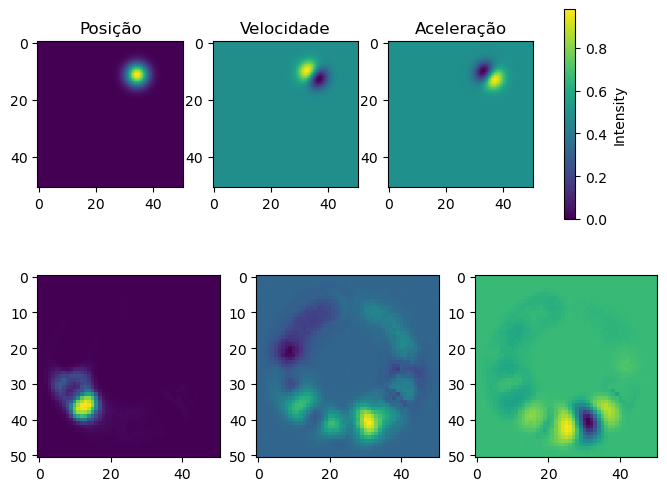

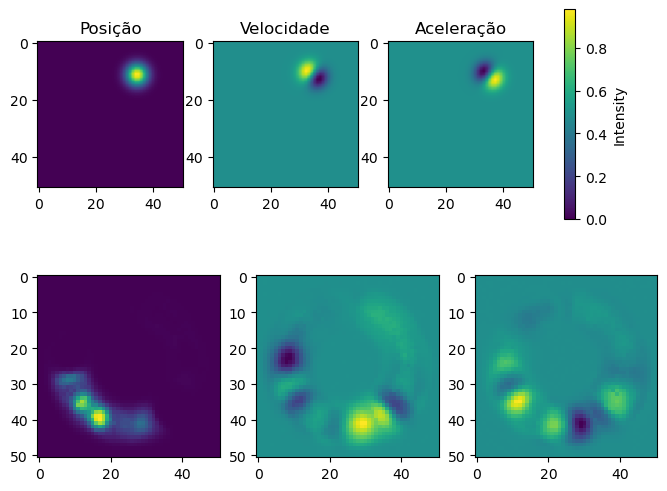

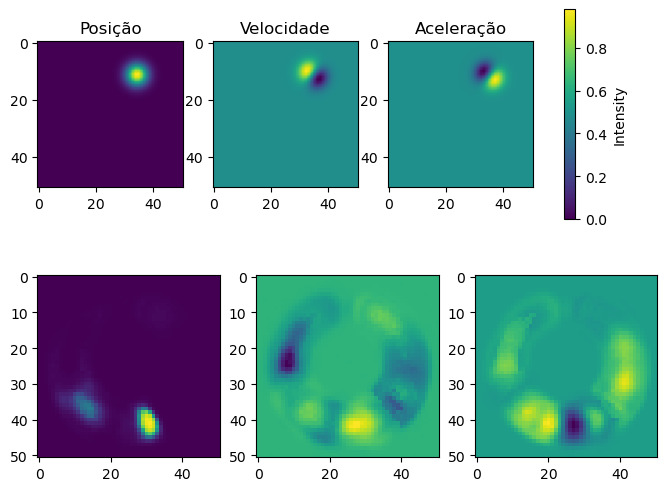

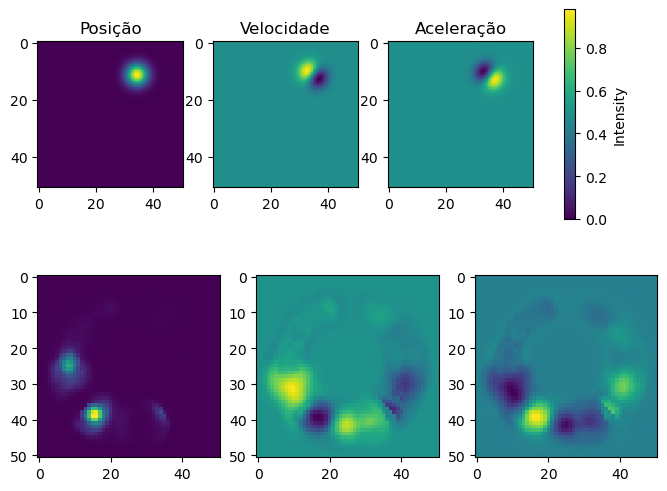

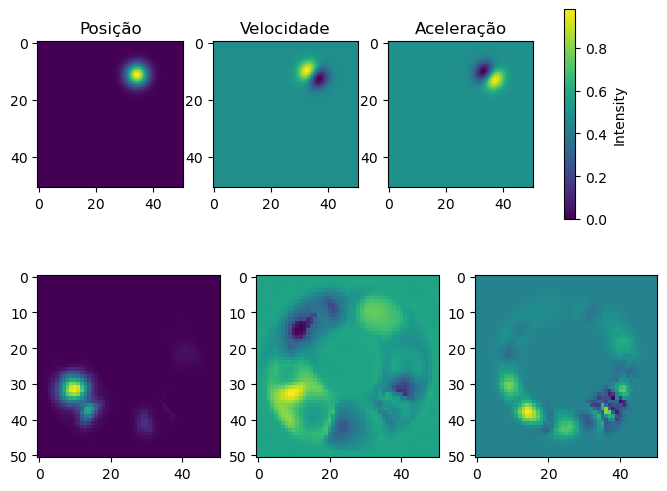

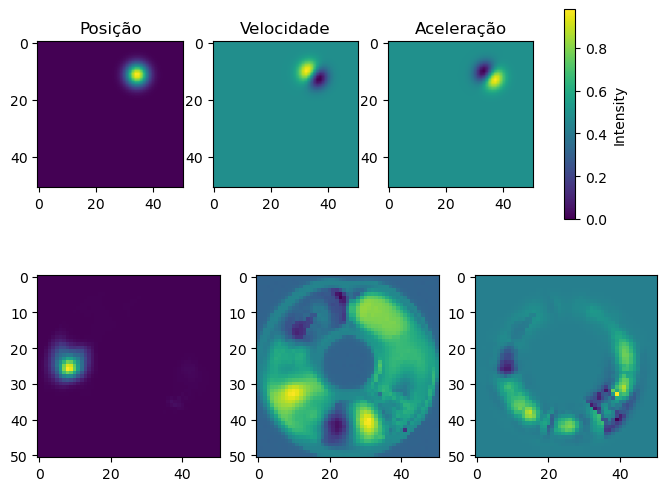

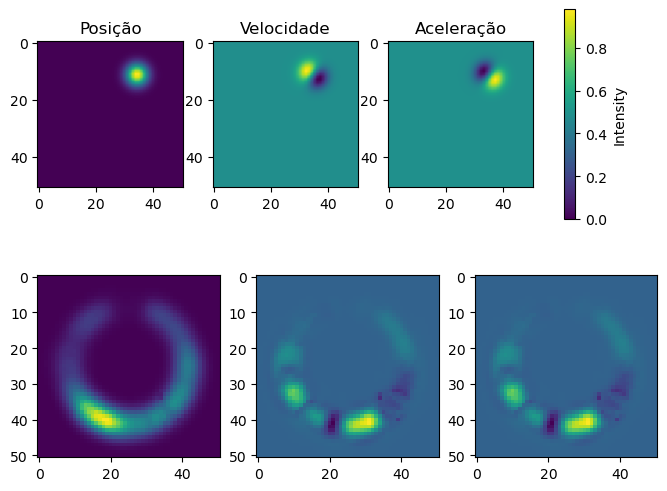

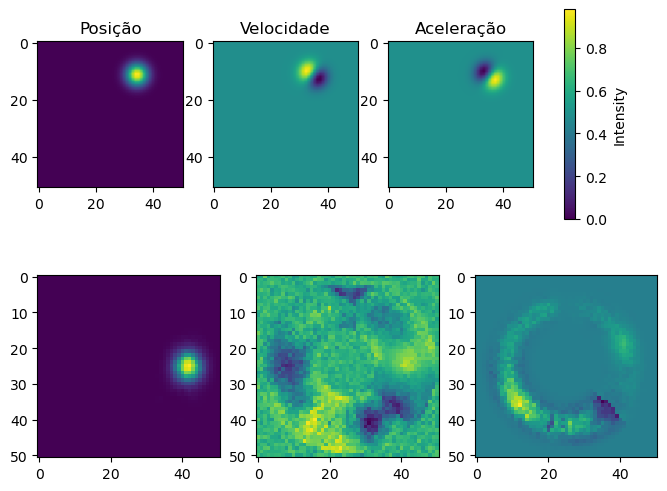

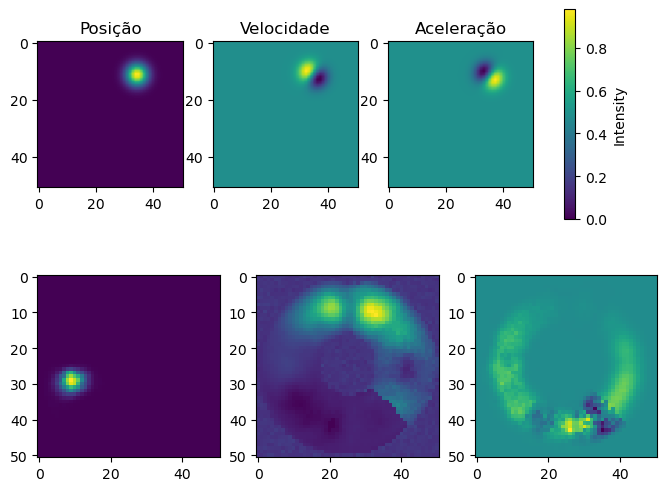

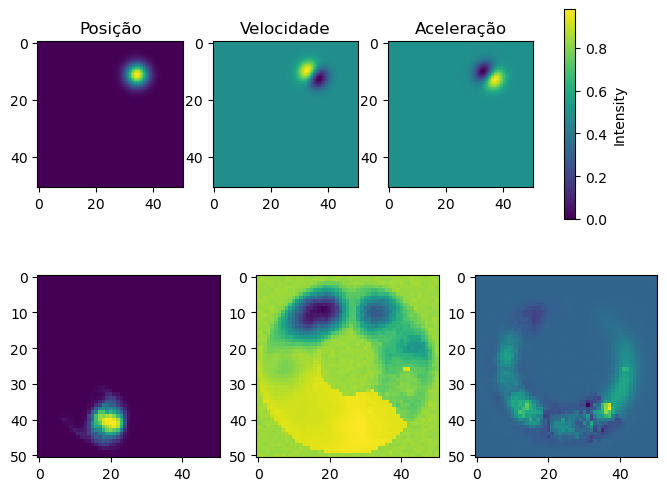

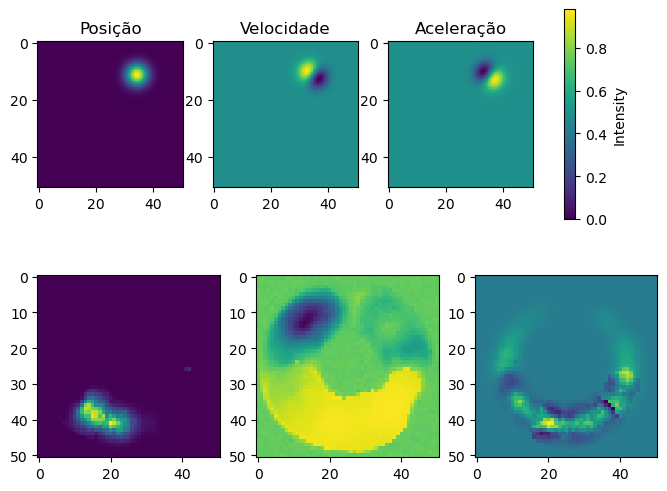

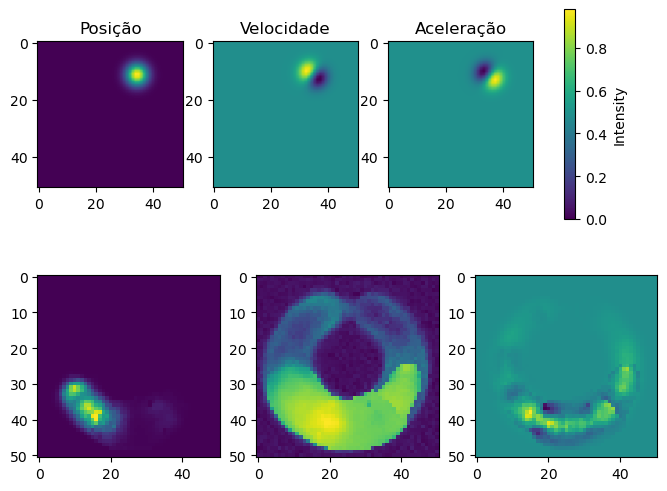

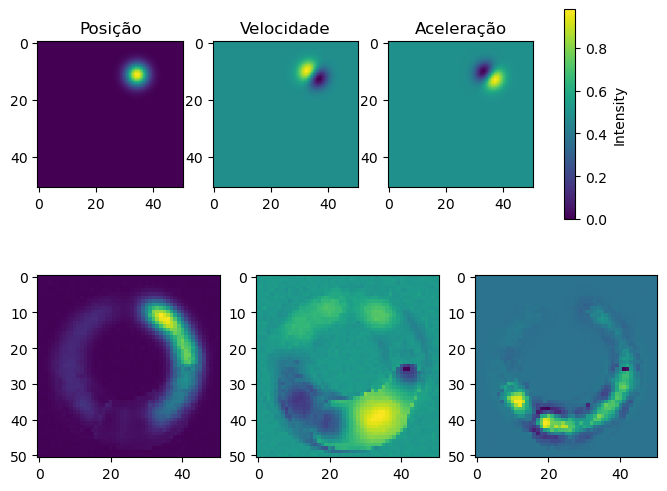

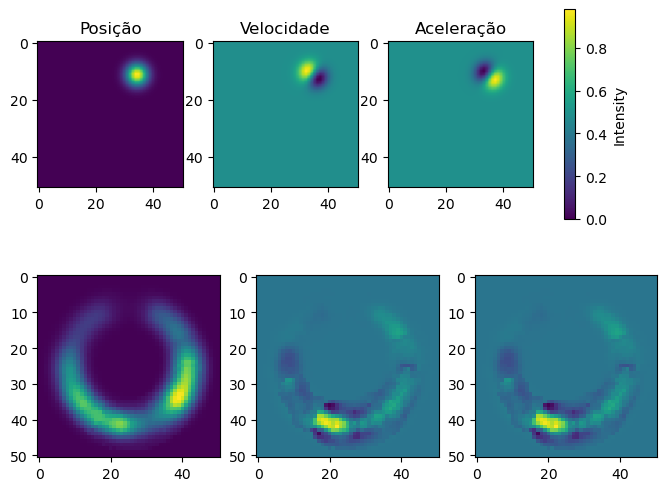

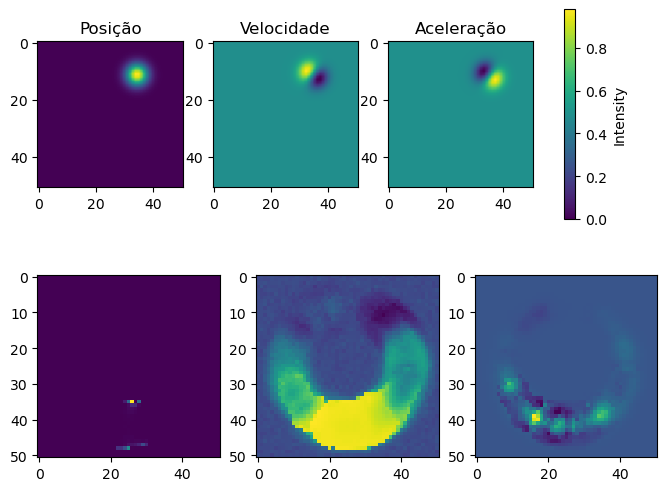

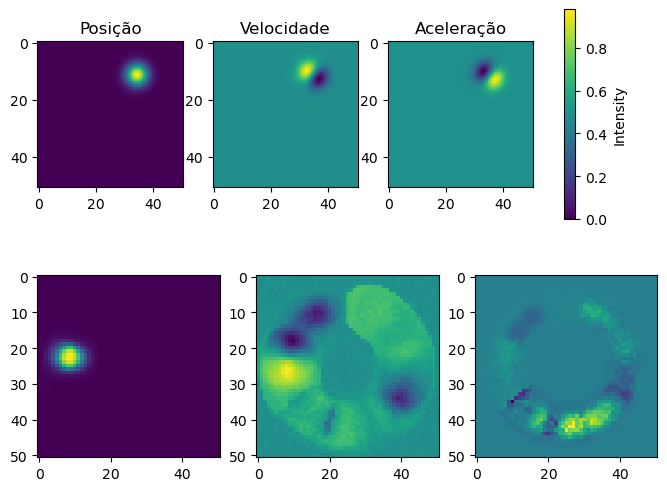

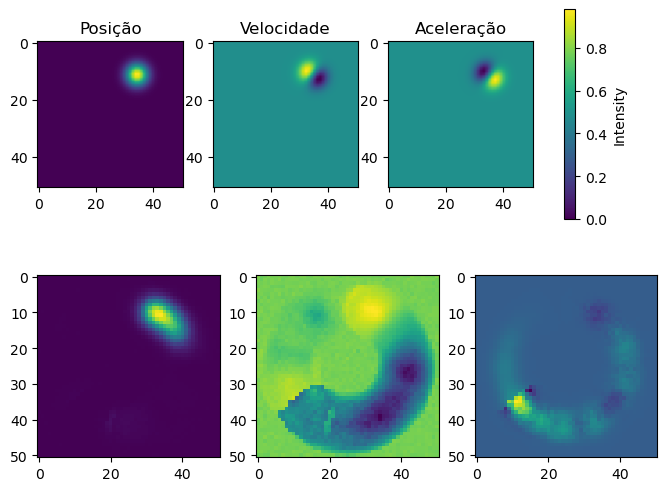

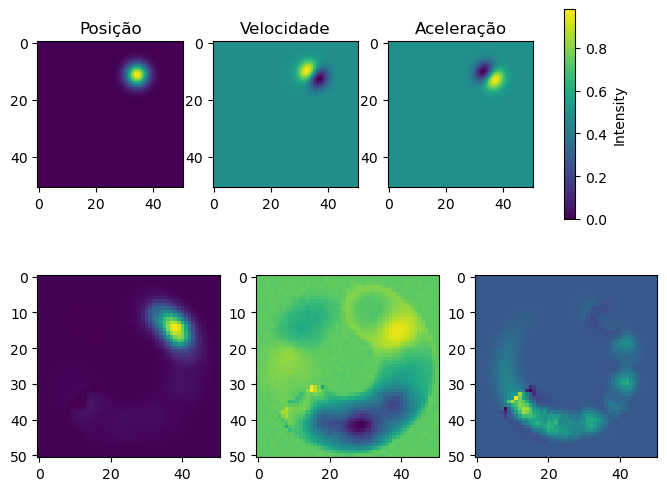

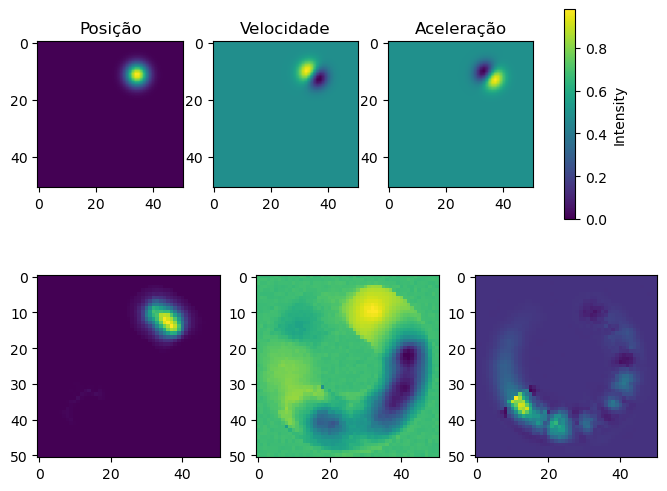

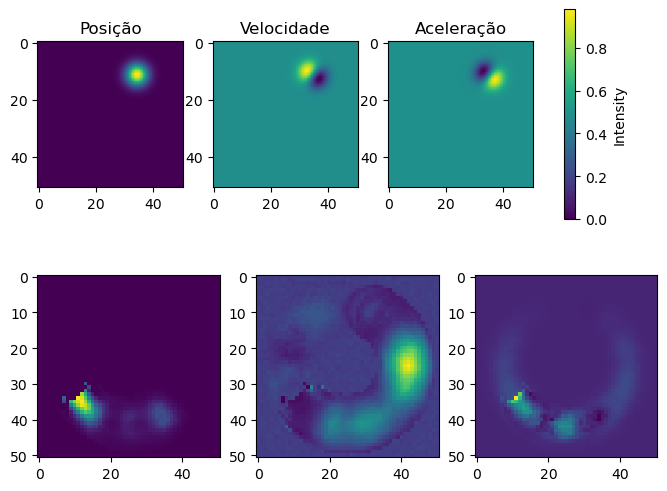

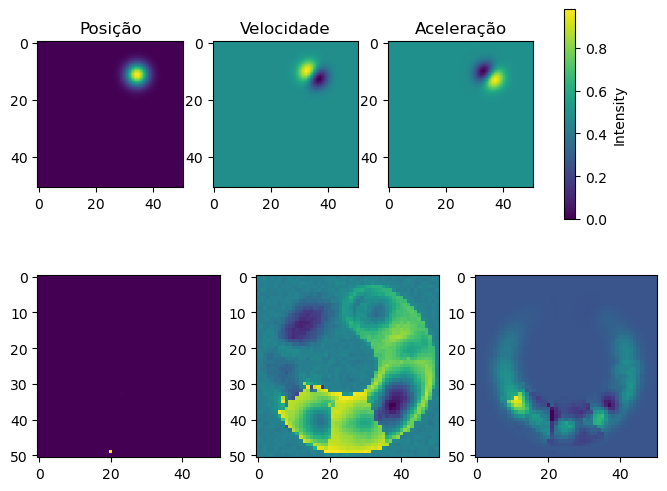

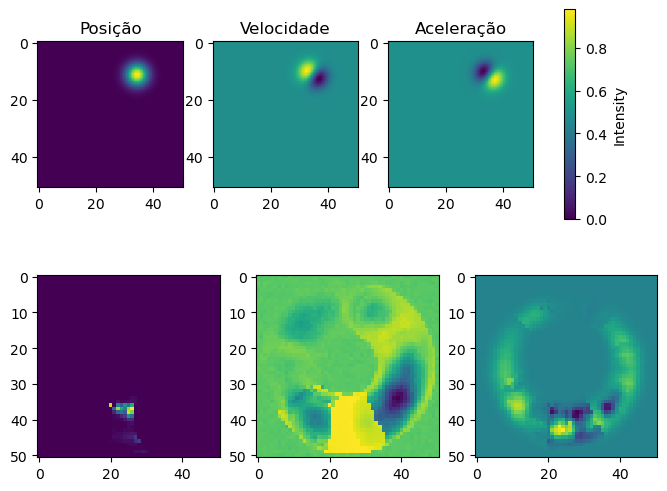

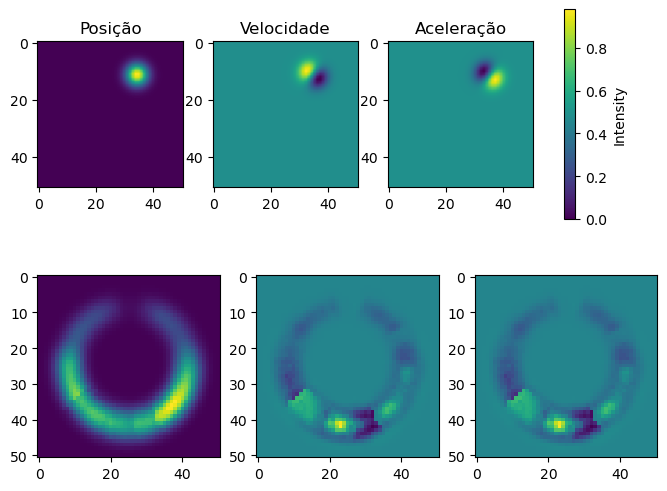

In [ ]:
loss_list = {}
loss_list['recon_loss'] = []
#loss_list['sindy_loss_x'] =[]
loss_list['sindy_loss_ddx'] = []
loss_list['sindy_loss_z'] = []
loss_list['sindy_regular_loss'] = []
loss_list['tot'] = []
loss_val_list = []

for experiment in range(0,10):
    epoch =1
    model = Autoencoder(params).to(device)
    print('-'*50)
    print(f'Experiment number {experiment}')
    while epoch <= epochs:
        
        if epoch % 40 ==0:
            print(f"epoch: [{epoch}/ {epochs}]")
        #print(f"epoch: [{epoch}/ {epochs}]")
        
        train_step(loss_list)
        
        validation_step(loss_val_list)
        
        print_loss(epoch, loss_rate, loss_list)

        save_model(epoch, saving_rate,experiment)
        
        sequential_threshold(epoch,seq_thres)

        plot_validation_comparison(epoch, val_print_rate)
        
        if epoch % equation_rate == 0 and epoch>1:
            print_model(epoch,experiment)
            data = pd.DataFrame.from_dict(loss_list)
            data.to_csv(path + 'data'+str(experiment)+'_'+str(epoch)+'epochs'+'.csv')
        epoch = epoch + 1
    print("Done!")

## Avaliação dos resultados


In [ ]:
def plot_validation_comparison(val_rate):

    X_p, dX_p,ddX_p,z_p,dz_p = validation_data['x'], validation_data['dx'], validation_data['ddx'], validation_data['z'], validation_data['dz']

    X_pred, dX_pred, ddX_pred, z_pred, dz_pred, ddz_pred,scindy_predict = model(X_val,dX_val, ddX_val)

    X_pred = X_pred.cpu()
    dX_pred = dX_pred.cpu()
    ddX_pred = ddX_pred.cpu()


    fig, axs = plt.subplots(2, 3, figsize=(8, 6))  # 5 rows, 1 column

    # Plot the first subplot
    im1 = axs[0,0].imshow(X_p[0].reshape(51,51))
    axs[0,0].set_title('Posição')
    cbar1 = fig.colorbar(im1, ax=axs[0])
    cbar1.set_label('Intensity')
    im2 = axs[0,1].imshow(dX_p[0].reshape(51,51))
    axs[0,1].set_title('Velocidade')
    im3 = axs[0,2].imshow(ddX_p[0].reshape(51,51))
    axs[0,2].set_title('Aceleração')
    im1 = axs[1,0].imshow(X_pred[0].reshape(51,51))
    cbar1 = fig.colorbar(im1, ax=axs[0])
    im2 = axs[1,1].imshow(dX_pred[0].reshape(51,51))
    im3 = axs[1,2].imshow(ddX_pred[0].reshape(51,51))


#plt.imshow(x0[0].reshape(51,51))

#plt.plot(loss_list['tot'])
#plt.plot(loss_list['sindy_loss_z'])
#plt.plot(loss_list['sindy_loss_x'])

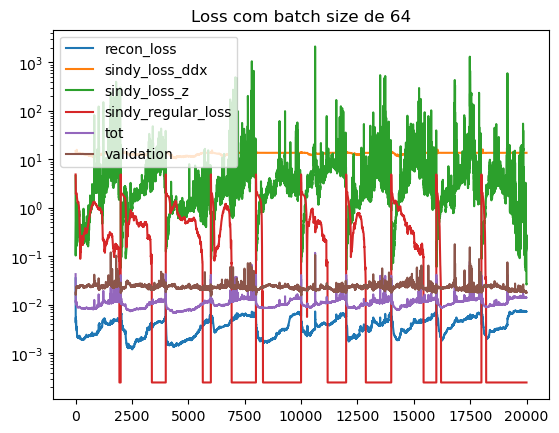

In [ ]:
# Plot loss
def plot_losses(loss_list, epoch):    
    data = pd.DataFrame.from_dict(loss_list)
    data.to_csv('./data'+'_'+str(epoch)+'epochs'+'.csv')
    for key in loss_list.keys():
        plt.semilogy((loss_list[key]),label = key)
    plt.semilogy((loss_val_list),label = 'validation')    
    plt.legend(loc = 'best')
    plt.title('Loss com batch size de '+str(batch_size))


plot_losses(loss_list, epochs)